# Executable Jupyter notebook 1: Simulated data

In [1]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
import seaborn as sns
from matplotlib import pylab as plt
import matplotlib as mpl
from statsmodels.regression.linear_model import OLS

def plot_lr(true_coefs, est_coefs, pvals):
    n_feat = len(est_coefs)
    where_sign = pvals < 0.05
    plt.figure(figsize=(15, 7))
    plt.scatter(np.arange(X.shape[1]), true_coefs, color='black', label='true betas', alpha=0.5)
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, color='red', label='estimated betas', alpha=0.5)
    # print significant betas
    axes = plt.gca()
    y_max, _ = axes.get_ylim()
    sign_y = np.sum(where_sign) * [y_max]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1))
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right')

def plot_regr_paths(coefs, accs, nonzeros, C_grid):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = coefs.shape[1]
    print(n_feat)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)   
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    X_colnames = np.arange(0, n_feat + 1, 1)
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=8.5, markerscale=10)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    axarr[1].plot(np.arange(len(accs)), accs, color='#000000',
                     linewidth=3)
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0.0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].set_title('LASSO: Out-of-sample accuracy ($R^2$ score)', fontsize=16)
    return my_colors

def clip_pvals(pvals):
    pvals[pvals == 0] = np.finfo(pvals.dtype).eps
    return pvals

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = next(iter(folder))

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = clf.score(X[test_inds, :], y[test_inds])

            sample_accs.append(acc)        
            sample_coef.append(clf.coef_)

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        notzero = np.count_nonzero(mean_coefs)
        print("alpha: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero))
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2)

In [3]:
def infpred_plot(unbiased_acc_list, lr_pvalues, coef_list, n_feat=None, names=None):
    fig = plt.figure(figsize=(9, 9))
    sorter = unbiased_acc_list.argsort()[::-1]
    colors = mpl.cm.viridis_r(np.linspace(0.1, 0.9, len(sorter)))
    colors2 = mpl.cm.gray_r(np.linspace(0.1, 0.9, len(sorter)))

    for ii, idx in enumerate(sorter):
        acc = unbiased_acc_list[idx]
        non_zero = np.where(coef_list[idx])[0]
        xx = lr_pvalues[non_zero[:n_feat]]
        plt.plot(
            -np.log10(xx),
                     [acc] * len(xx), marker='o', linestyle='None',
                     color=colors[ii], zorder=-ii,
                     mew=5)

        xx2 = lr_pvalues[non_zero[n_feat:]]
        plt.plot(
            -np.log10(xx2),
                     [acc] * len(xx2), marker='o', linestyle='None',
                     color=colors2[ii], zorder=-ii,
                     mew=5)

    plt.axvline(
        -np.log10(0.05), color='red', linestyle='--', linewidth=3)
    plt.annotate('p < 0.05', xy=(-np.log10(0.045), 0.03), color='red', fontsize=14)
    plt.xlabel(r'significance [$-log_{10}(p)$]', fontsize=20, fontweight=150)
    plt.ylabel(r'prediction [$R^2$]', fontsize=20, fontweight=150)
    plt.ylim(0, 1)
    plt.grid(True)
    ax = plt.gca()
    ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_yticks(np.arange(0.01, 1, 0.01), minor=True)
    
    return fig

In [4]:
simulations = []

def run_lasso(X, y, comment, n_samples, n_feat,
              n_feat_relevant, C_grid):
    # ordinary least squares
    model = OLS(y, X)
    res = model.fit()
    lr_coefs = res.params
    lr_pvalues = clip_pvals(res.pvalues)

    # compute Lasso regularization paths
    coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

    plot_lr(true_coefs, lr_coefs, lr_pvalues)
    path_colors = plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)
    infpred_plot(
        acc_list, lr_pvalues, coef_list, n_feat=n_feat_relevant)
    
    simulations.append(
        dict(X=X, y=y, comment=comment,
             n_samples=n_samples, n_feat=n_feat,
             n_feat_relevant=n_feat_relevant,
             pvals=lr_pvalues,
             coefs=coef_list,
             acc_list=acc_list))
    

# __100 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.57 active_coefs: 40
alpha: 0.0127 acc: 0.60 active_coefs: 40
alpha: 0.0162 acc: 0.64 active_coefs: 40
alpha: 0.0205 acc: 0.68 active_coefs: 40
alpha: 0.0261 acc: 0.72 active_coefs: 40
alpha: 0.0332 acc: 0.76 active_coefs: 40
alpha: 0.0422 acc: 0.79 active_coefs: 40
alpha: 0.0536 acc: 0.80 active_coefs: 40
alpha: 0.0681 acc: 0.80 active_coefs: 40
alpha: 0.0866 acc: 0.80 active_coefs: 39
alpha: 0.1101 acc: 0.80 active_coefs: 32
alpha: 0.1399 acc: 0.78 active_coefs: 24
alpha: 0.1778 acc: 0.76 active_coefs: 19
alpha: 0.2260 acc: 0.70 active_coefs: 15
alpha: 0.2873 acc: 0.62 active_coefs: 13
alpha: 0.3652 acc: 0.55 active_coefs: 7
alpha: 0.4642 acc: 0.44 active_coefs: 6
alpha: 0.5900 acc: 0.32 active_coefs: 6
alpha: 0.7499 acc: 0.22 active_coefs: 4
alpha: 0.9532 acc: 0.04 active_coefs: 2
alpha: 1.2115 acc: -0.19 active_coefs: 2
alpha: 1.5399 acc: -0.22 active_coefs: 1
alpha: 1.9573 acc: -0.22 active_coefs: 0
alpha: 2.4879 acc: -0.22 active_coefs: 0
alpha: 3.1623 acc: -0

RuntimeError: In FT2Font: Can not load face.

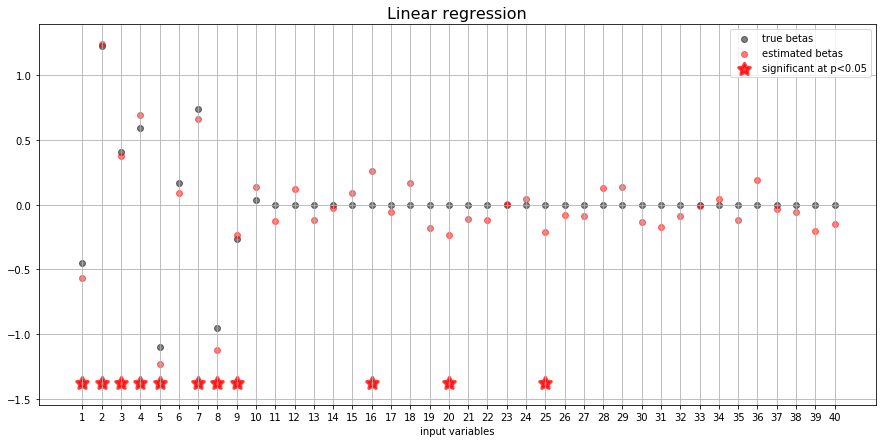

RuntimeError: In FT2Font: Can not load face.

RuntimeError: In FT2Font: Can not load face.

In [5]:
comment = "dataset: 10/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [ ]:
%debug

> /Users/admin/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py(568)_get_font()
    566         cached_font = self._fonts.get(basename)
    567         if cached_font is None and os.path.exists(basename):
--> 568             cached_font = get_font(basename)
    569             self._fonts[basename] = cached_font
    570             self._fonts[cached_font.postscript_name] = cached_font

'/Users/admin/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf'


In [ ]:
comment = "dataset: 20/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 20
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

C_grid = np.logspace(-2, 0.5, 25)
run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0100 acc: 0.95 active_coefs: 40
alpha: 0.0127 acc: 0.95 active_coefs: 40
alpha: 0.0162 acc: 0.95 active_coefs: 40
alpha: 0.0205 acc: 0.95 active_coefs: 40
alpha: 0.0261 acc: 0.96 active_coefs: 40
alpha: 0.0332 acc: 0.96 active_coefs: 40
alpha: 0.0422 acc: 0.96 active_coefs: 40
alpha: 0.0536 acc: 0.96 active_coefs: 40
alpha: 0.0681 acc: 0.96 active_coefs: 38
alpha: 0.0866 acc: 0.96 active_coefs: 38
alpha: 0.1101 acc: 0.95 active_coefs: 37
alpha: 0.1399 acc: 0.93 active_coefs: 37
alpha: 0.1778 acc: 0.90 active_coefs: 34
alpha: 0.2260 acc: 0.86 active_coefs: 33
alpha: 0.2873 acc: 0.81 active_coefs: 31
alpha: 0.3652 acc: 0.75 active_coefs: 29
alpha: 0.4642 acc: 0.68 active_coefs: 28
alpha: 0.5900 acc: 0.58 active_coefs: 26
alpha: 0.7499 acc: 0.43 active_coefs: 23
alpha: 0.9532 acc: 0.22 active_coefs: 18
alpha: 1.2115 acc: -0.06 active_coefs: 14
alpha: 1.5399 acc: -0.25 active_coefs: 10
alpha: 1.9573 acc: -0.36 active_coefs: 5
alpha: 2.4879 acc: -0.45 active_coefs: 1
alpha: 3.1623 

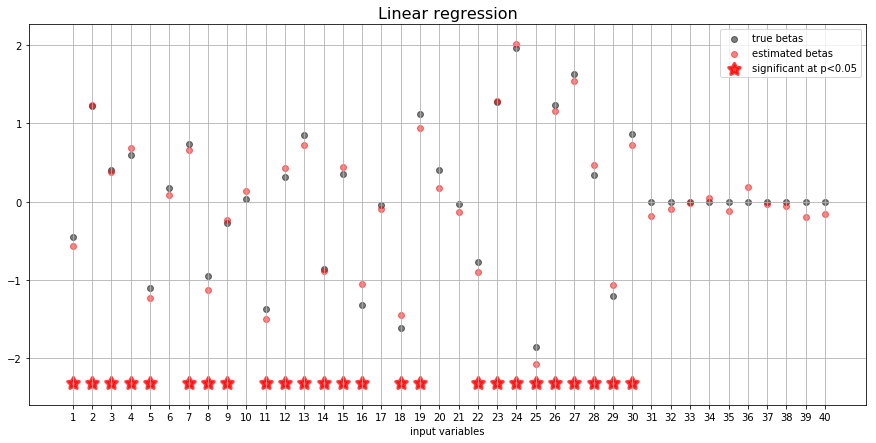

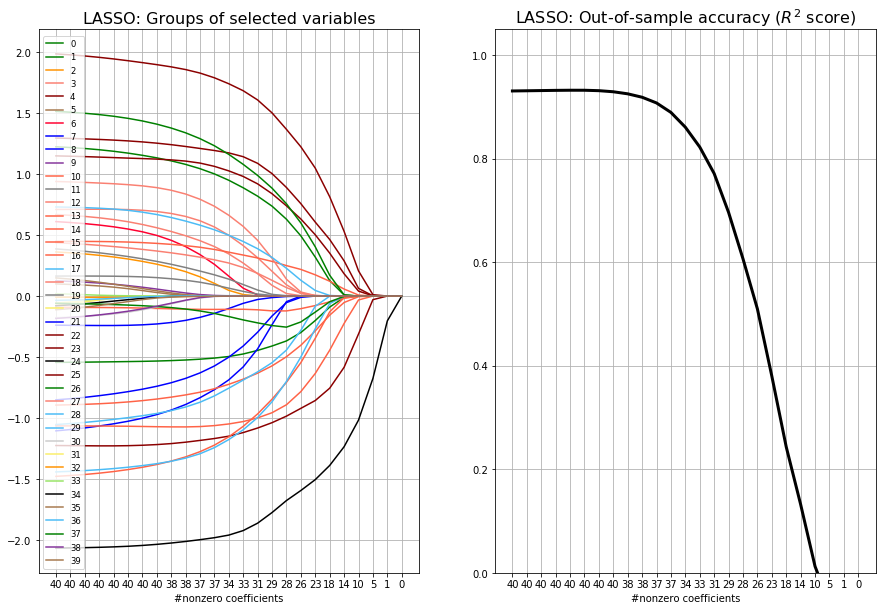

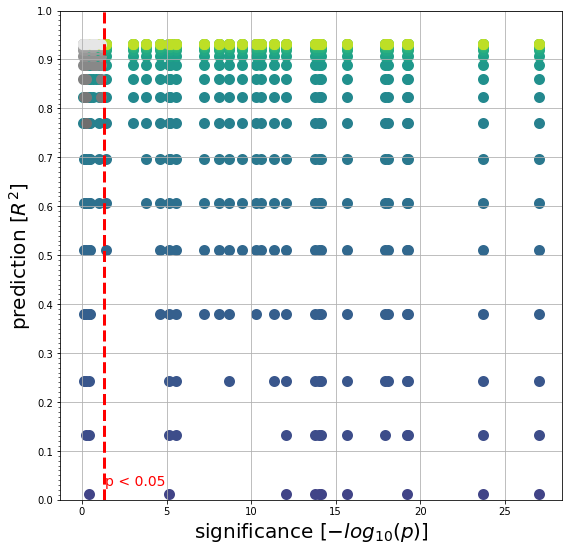

In [96]:
comment = "dataset: 30/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 30
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0100 acc: 0.97 active_coefs: 40
alpha: 0.0127 acc: 0.97 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 40
alpha: 0.0332 acc: 0.98 active_coefs: 40
alpha: 0.0422 acc: 0.98 active_coefs: 40
alpha: 0.0536 acc: 0.98 active_coefs: 40
alpha: 0.0681 acc: 0.98 active_coefs: 40
alpha: 0.0866 acc: 0.97 active_coefs: 40
alpha: 0.1101 acc: 0.96 active_coefs: 40
alpha: 0.1399 acc: 0.94 active_coefs: 40
alpha: 0.1778 acc: 0.92 active_coefs: 40
alpha: 0.2260 acc: 0.88 active_coefs: 38
alpha: 0.2873 acc: 0.82 active_coefs: 36
alpha: 0.3652 acc: 0.75 active_coefs: 36
alpha: 0.4642 acc: 0.68 active_coefs: 33
alpha: 0.5900 acc: 0.59 active_coefs: 30
alpha: 0.7499 acc: 0.47 active_coefs: 29
alpha: 0.9532 acc: 0.30 active_coefs: 21
alpha: 1.2115 acc: 0.09 active_coefs: 17
alpha: 1.5399 acc: -0.11 active_coefs: 14
alpha: 1.9573 acc: -0.25 active_coefs: 8
alpha: 2.4879 acc: -0.31 active_coefs: 4
alpha: 3.1623 a

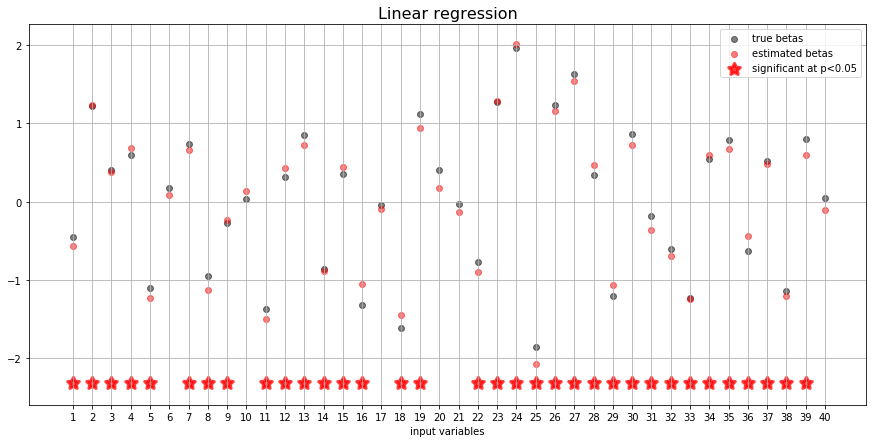

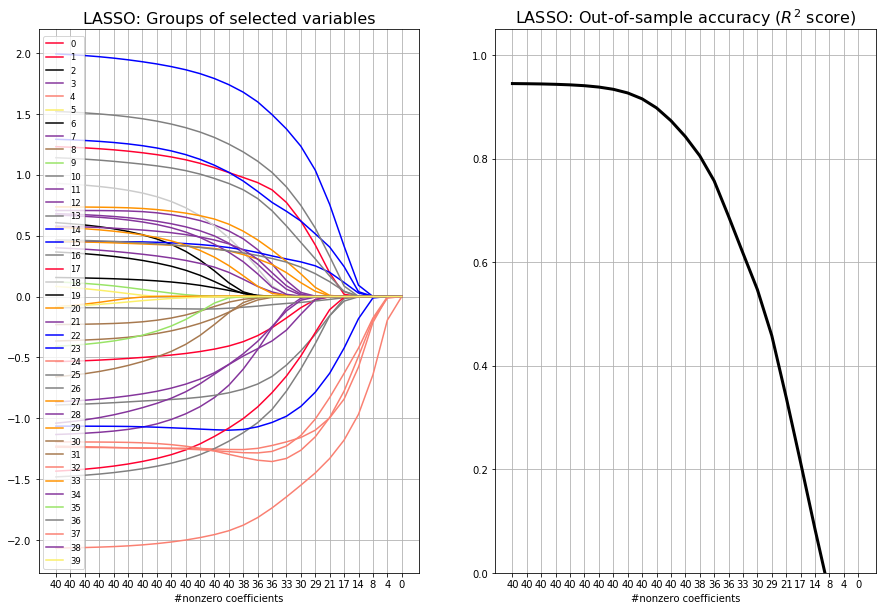

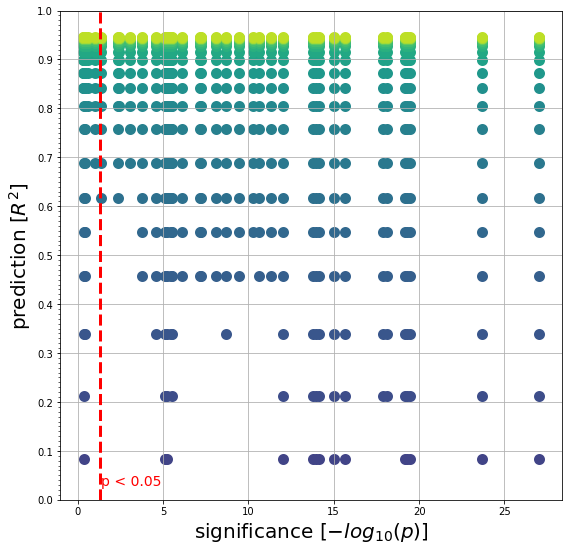

In [97]:
comment = "dataset: 40/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

# __1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.93 active_coefs: 40
alpha: 0.0127 acc: 0.93 active_coefs: 40
alpha: 0.0162 acc: 0.94 active_coefs: 40
alpha: 0.0205 acc: 0.94 active_coefs: 40
alpha: 0.0261 acc: 0.94 active_coefs: 38
alpha: 0.0332 acc: 0.94 active_coefs: 36
alpha: 0.0422 acc: 0.94 active_coefs: 28
alpha: 0.0536 acc: 0.94 active_coefs: 20
alpha: 0.0681 acc: 0.93 active_coefs: 16
alpha: 0.0866 acc: 0.93 active_coefs: 12
alpha: 0.1101 acc: 0.93 active_coefs: 11
alpha: 0.1399 acc: 0.92 active_coefs: 10
alpha: 0.1778 acc: 0.91 active_coefs: 10
alpha: 0.2260 acc: 0.90 active_coefs: 9
alpha: 0.2873 acc: 0.88 active_coefs: 8
alpha: 0.3652 acc: 0.86 active_coefs: 8
alpha: 0.4642 acc: 0.81 active_coefs: 8
alpha: 0.5900 acc: 0.75 active_coefs: 7
alpha: 0.7499 acc: 0.67 active_coefs: 5
alpha: 0.9532 acc: 0.56 active_coefs: 4
alpha: 1.2115 acc: 0.41 active_coefs: 3
alpha: 1.5399 acc: 0.19 active_coefs: 3
alpha: 1.9573 acc: 0.09 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 a

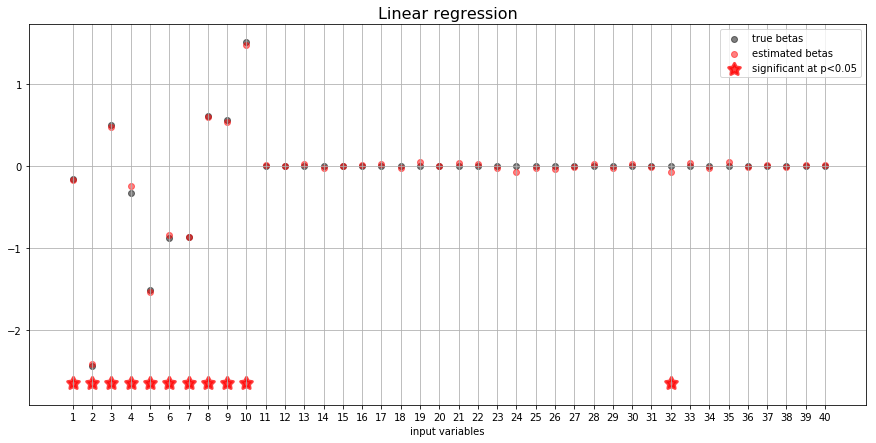

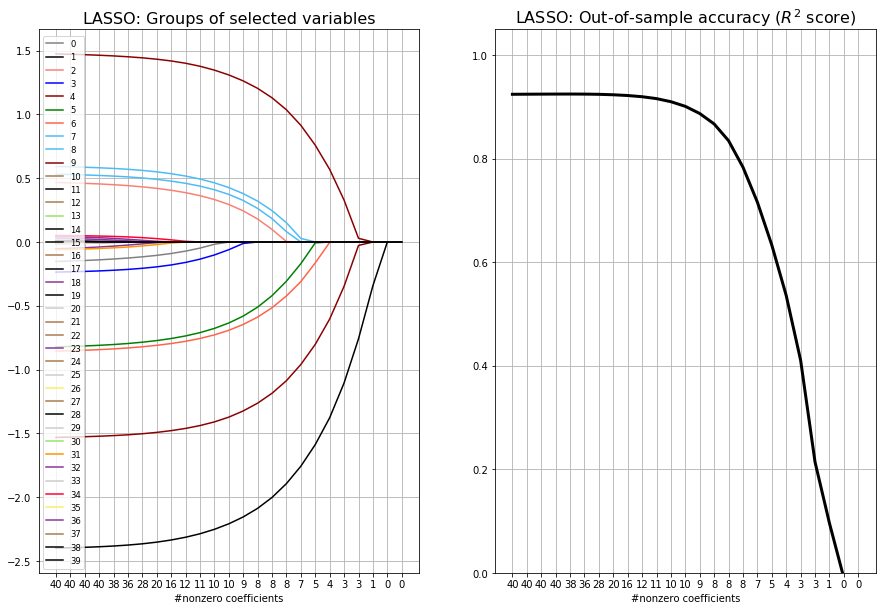

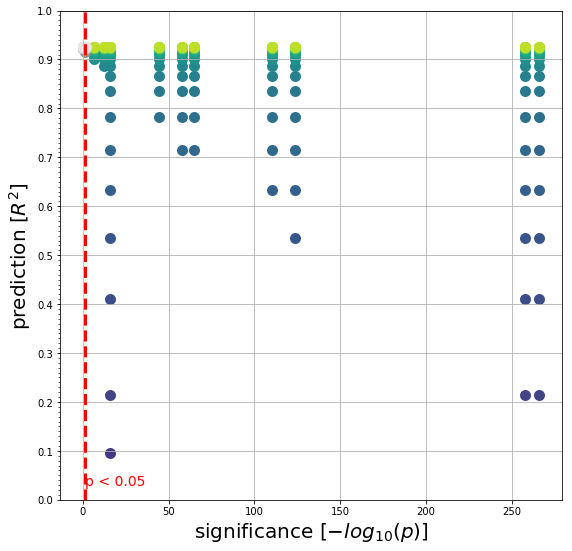

In [98]:
comment = "dataset: 10/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

C_grid = np.logspace(-2, 0.5, 25)
run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0100 acc: 0.96 active_coefs: 40
alpha: 0.0127 acc: 0.96 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 38
alpha: 0.0332 acc: 0.97 active_coefs: 37
alpha: 0.0422 acc: 0.97 active_coefs: 35
alpha: 0.0536 acc: 0.97 active_coefs: 29
alpha: 0.0681 acc: 0.97 active_coefs: 24
alpha: 0.0866 acc: 0.96 active_coefs: 22
alpha: 0.1101 acc: 0.96 active_coefs: 21
alpha: 0.1399 acc: 0.96 active_coefs: 21
alpha: 0.1778 acc: 0.95 active_coefs: 19
alpha: 0.2260 acc: 0.94 active_coefs: 19
alpha: 0.2873 acc: 0.93 active_coefs: 18
alpha: 0.3652 acc: 0.90 active_coefs: 17
alpha: 0.4642 acc: 0.86 active_coefs: 17
alpha: 0.5900 acc: 0.81 active_coefs: 17
alpha: 0.7499 acc: 0.73 active_coefs: 12
alpha: 0.9532 acc: 0.61 active_coefs: 11
alpha: 1.2115 acc: 0.43 active_coefs: 10
alpha: 1.5399 acc: 0.19 active_coefs: 6
alpha: 1.9573 acc: 0.08 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 1
alpha: 3.1623 acc:

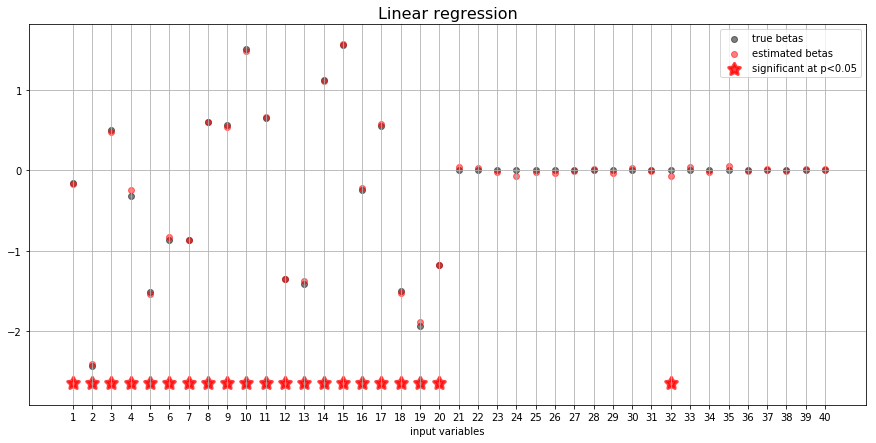

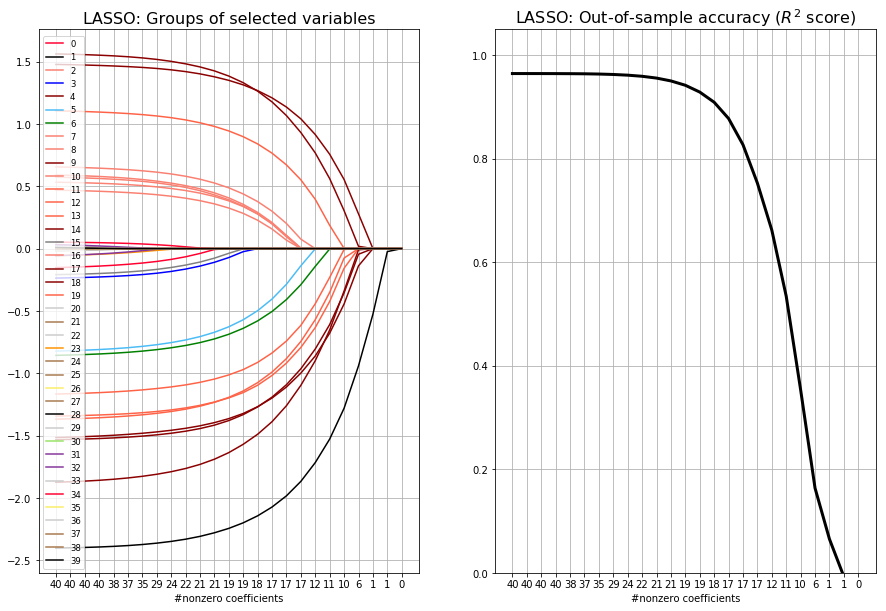

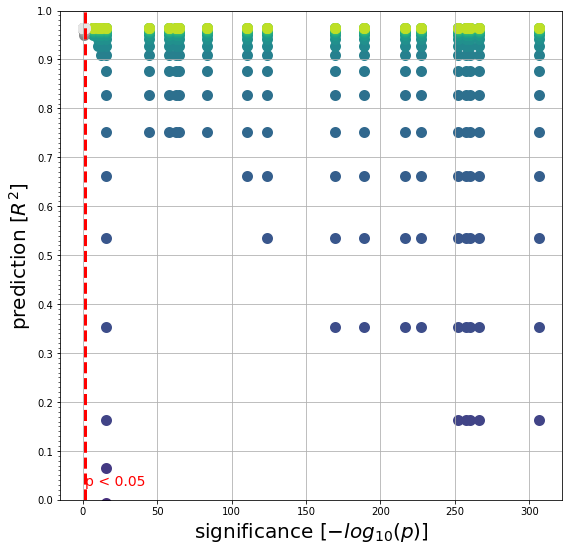

In [99]:
comment = "dataset: 20/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samplebs = 1000
n_feat = 40
n_feat_relevant = 20
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0100 acc: 0.97 active_coefs: 40
alpha: 0.0127 acc: 0.97 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 40
alpha: 0.0332 acc: 0.97 active_coefs: 39
alpha: 0.0422 acc: 0.97 active_coefs: 37
alpha: 0.0536 acc: 0.97 active_coefs: 35
alpha: 0.0681 acc: 0.97 active_coefs: 32
alpha: 0.0866 acc: 0.97 active_coefs: 31
alpha: 0.1101 acc: 0.97 active_coefs: 30
alpha: 0.1399 acc: 0.96 active_coefs: 30
alpha: 0.1778 acc: 0.95 active_coefs: 28
alpha: 0.2260 acc: 0.94 active_coefs: 28
alpha: 0.2873 acc: 0.92 active_coefs: 26
alpha: 0.3652 acc: 0.90 active_coefs: 24
alpha: 0.4642 acc: 0.85 active_coefs: 23
alpha: 0.5900 acc: 0.80 active_coefs: 19
alpha: 0.7499 acc: 0.72 active_coefs: 15
alpha: 0.9532 acc: 0.62 active_coefs: 13
alpha: 1.2115 acc: 0.44 active_coefs: 12
alpha: 1.5399 acc: 0.23 active_coefs: 7
alpha: 1.9573 acc: 0.10 active_coefs: 3
alpha: 2.4879 acc: 0.01 active_coefs: 1
alpha: 3.1623 acc: 

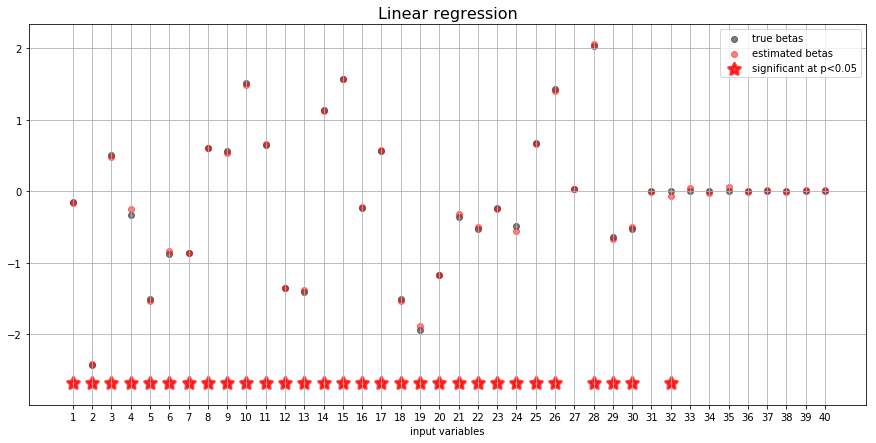

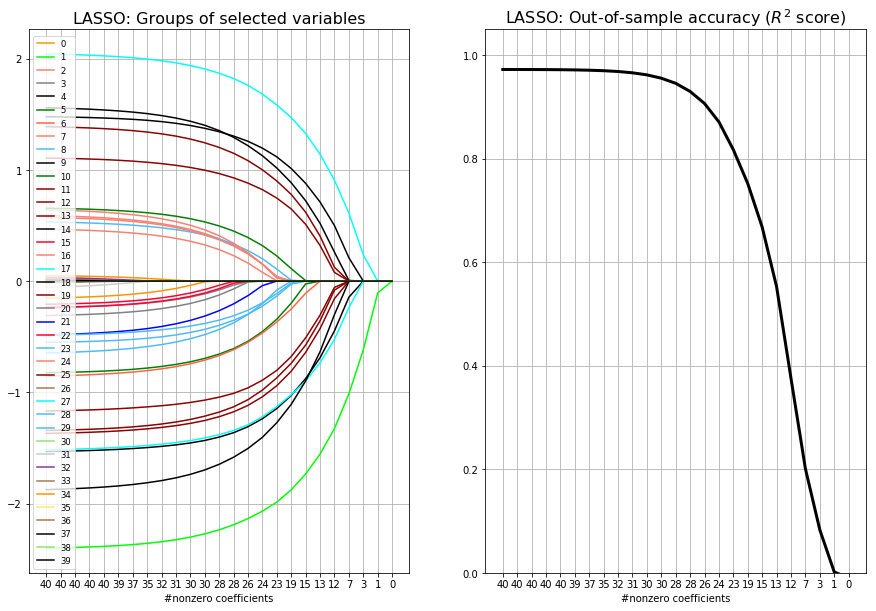

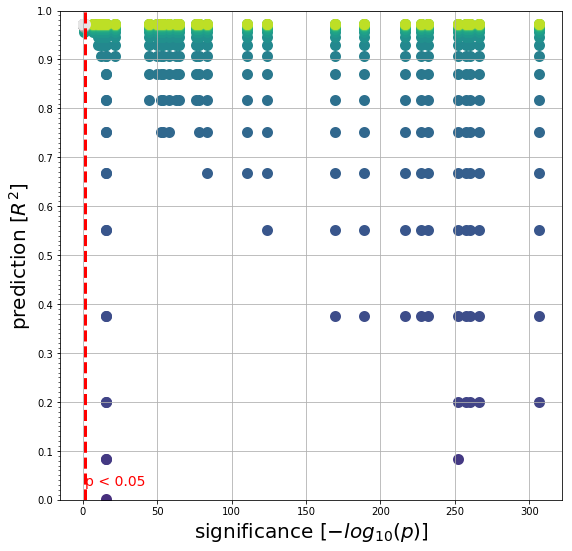

In [100]:
comment = "dataset: 30/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 30
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0100 acc: 0.98 active_coefs: 40
alpha: 0.0127 acc: 0.98 active_coefs: 40
alpha: 0.0162 acc: 0.98 active_coefs: 40
alpha: 0.0205 acc: 0.98 active_coefs: 40
alpha: 0.0261 acc: 0.98 active_coefs: 40
alpha: 0.0332 acc: 0.98 active_coefs: 40
alpha: 0.0422 acc: 0.98 active_coefs: 40
alpha: 0.0536 acc: 0.98 active_coefs: 40
alpha: 0.0681 acc: 0.98 active_coefs: 39
alpha: 0.0866 acc: 0.97 active_coefs: 39
alpha: 0.1101 acc: 0.97 active_coefs: 39
alpha: 0.1399 acc: 0.96 active_coefs: 39
alpha: 0.1778 acc: 0.95 active_coefs: 39
alpha: 0.2260 acc: 0.94 active_coefs: 36
alpha: 0.2873 acc: 0.92 active_coefs: 34
alpha: 0.3652 acc: 0.89 active_coefs: 31
alpha: 0.4642 acc: 0.85 active_coefs: 29
alpha: 0.5900 acc: 0.79 active_coefs: 26
alpha: 0.7499 acc: 0.71 active_coefs: 21
alpha: 0.9532 acc: 0.61 active_coefs: 16
alpha: 1.2115 acc: 0.45 active_coefs: 15
alpha: 1.5399 acc: 0.28 active_coefs: 9
alpha: 1.9573 acc: 0.12 active_coefs: 6
alpha: 2.4879 acc: 0.01 active_coefs: 2
alpha: 3.1623 acc: 

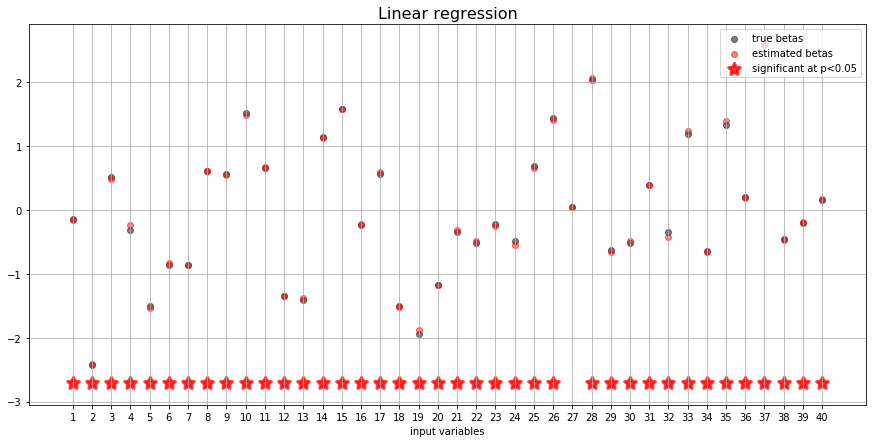

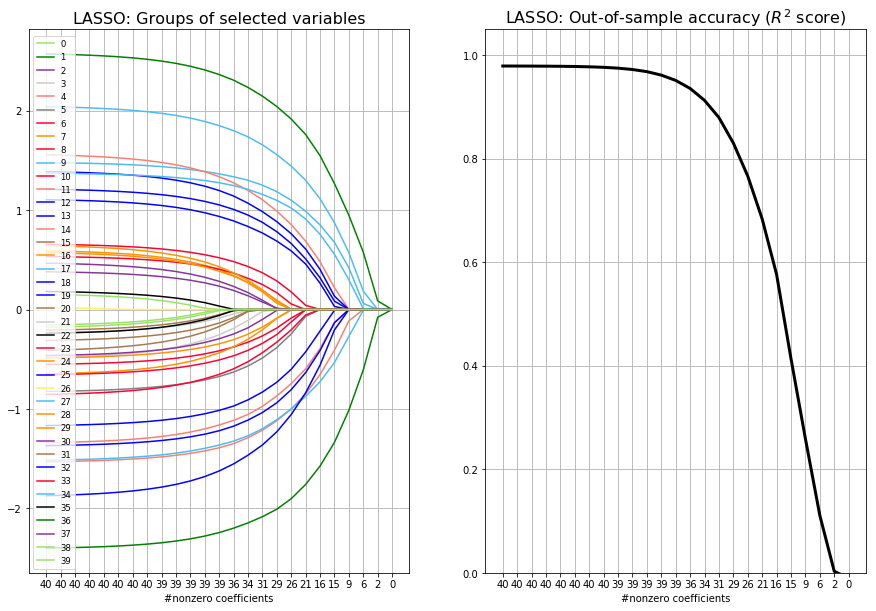

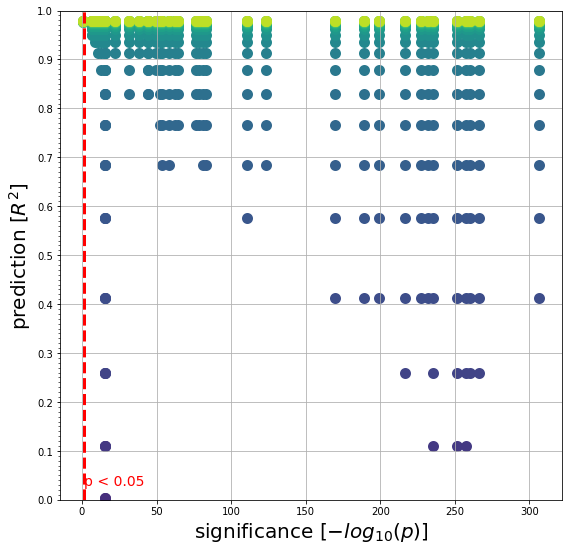

In [101]:
comment = "dataset: 40/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

# __100 samples, 40 variables, error = none__

alpha: 0.0010 acc: 1.00 active_coefs: 10
alpha: 0.0014 acc: 1.00 active_coefs: 10
alpha: 0.0020 acc: 1.00 active_coefs: 10
alpha: 0.0027 acc: 1.00 active_coefs: 10
alpha: 0.0038 acc: 1.00 active_coefs: 10
alpha: 0.0054 acc: 1.00 active_coefs: 10
alpha: 0.0075 acc: 1.00 active_coefs: 10
alpha: 0.0105 acc: 1.00 active_coefs: 10
alpha: 0.0147 acc: 1.00 active_coefs: 10
alpha: 0.0205 acc: 1.00 active_coefs: 10
alpha: 0.0287 acc: 1.00 active_coefs: 10
alpha: 0.0402 acc: 1.00 active_coefs: 10
alpha: 0.0562 acc: 1.00 active_coefs: 10
alpha: 0.0787 acc: 0.99 active_coefs: 10
alpha: 0.1101 acc: 0.99 active_coefs: 10
alpha: 0.1540 acc: 0.98 active_coefs: 10
alpha: 0.2154 acc: 0.96 active_coefs: 10
alpha: 0.3014 acc: 0.93 active_coefs: 10
alpha: 0.4217 acc: 0.89 active_coefs: 8
alpha: 0.5900 acc: 0.80 active_coefs: 7
alpha: 0.8254 acc: 0.68 active_coefs: 6
alpha: 1.1548 acc: 0.47 active_coefs: 5
alpha: 1.6156 acc: 0.18 active_coefs: 3
alpha: 2.2603 acc: -0.05 active_coefs: 1
alpha: 3.1623 acc: -0

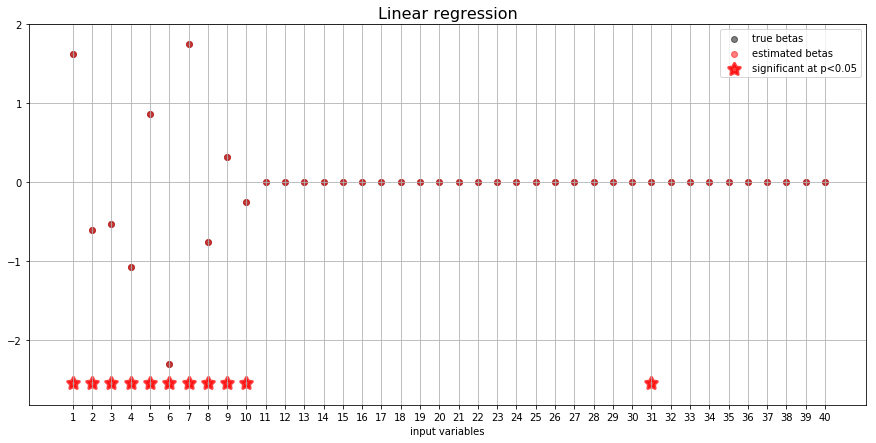

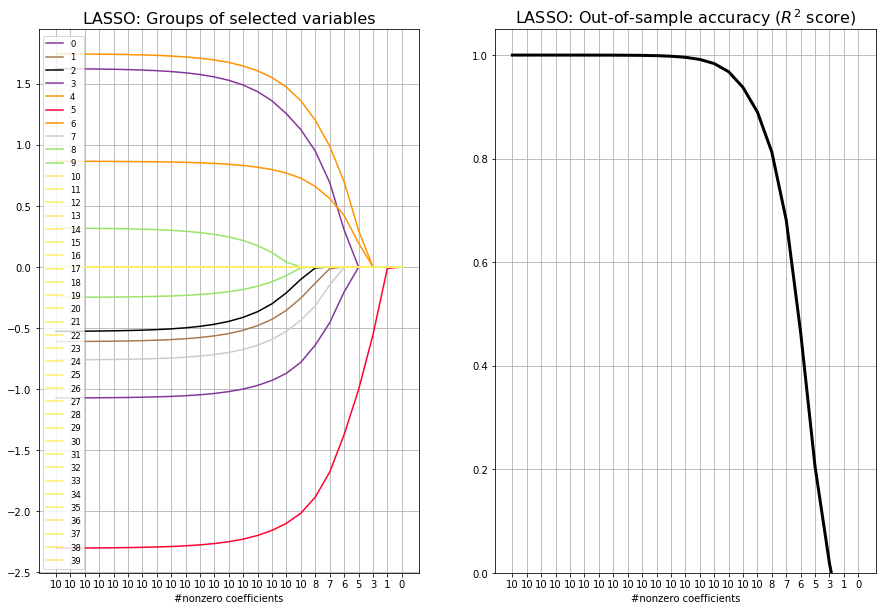

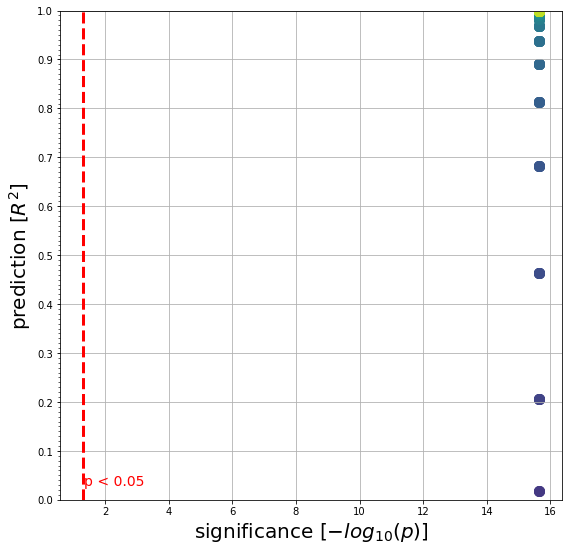

In [102]:
comment = "dataset: 10/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 10
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)
C_grid = np.logspace(-3, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 25
alpha: 0.0014 acc: 1.00 active_coefs: 24
alpha: 0.0020 acc: 1.00 active_coefs: 24
alpha: 0.0027 acc: 1.00 active_coefs: 24
alpha: 0.0038 acc: 1.00 active_coefs: 24
alpha: 0.0054 acc: 1.00 active_coefs: 24
alpha: 0.0075 acc: 1.00 active_coefs: 24
alpha: 0.0105 acc: 1.00 active_coefs: 24
alpha: 0.0147 acc: 1.00 active_coefs: 24
alpha: 0.0205 acc: 1.00 active_coefs: 24
alpha: 0.0287 acc: 1.00 active_coefs: 24
alpha: 0.0402 acc: 1.00 active_coefs: 22
alpha: 0.0562 acc: 1.00 active_coefs: 23
alpha: 0.0787 acc: 0.99 active_coefs: 23
alpha: 0.1101 acc: 0.98 active_coefs: 24
alpha: 0.1540 acc: 0.97 active_coefs: 24
alpha: 0.2154 acc: 0.94 active_coefs: 22
alpha: 0.3014 acc: 0.90 active_coefs: 20
alpha: 0.4217 acc: 0.83 active_coefs: 17
alpha: 0.5900 acc: 0.69 active_coefs: 14
alpha: 0.8254 acc: 0.39 active_coefs: 13
alpha: 1.1548 acc: 0.00 active_coefs: 12
alpha: 1.6156 acc: -0.69 active_coefs: 7
alpha: 2.2603 acc: -1.09 active_coefs: 2
alpha: 3.1623 ac

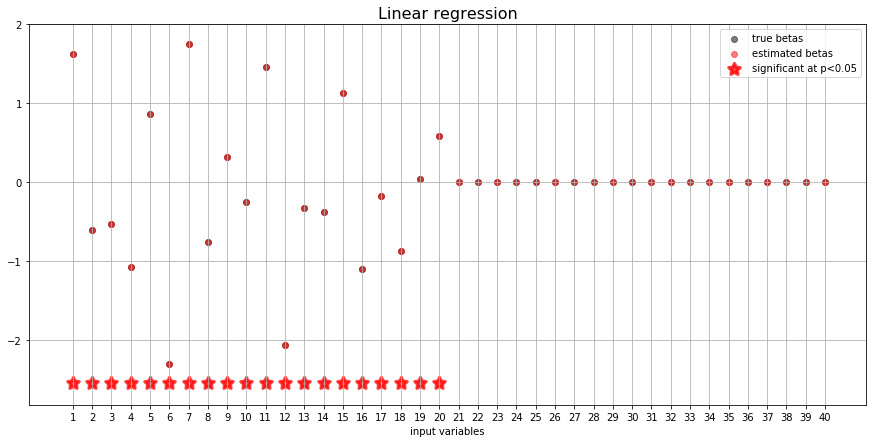

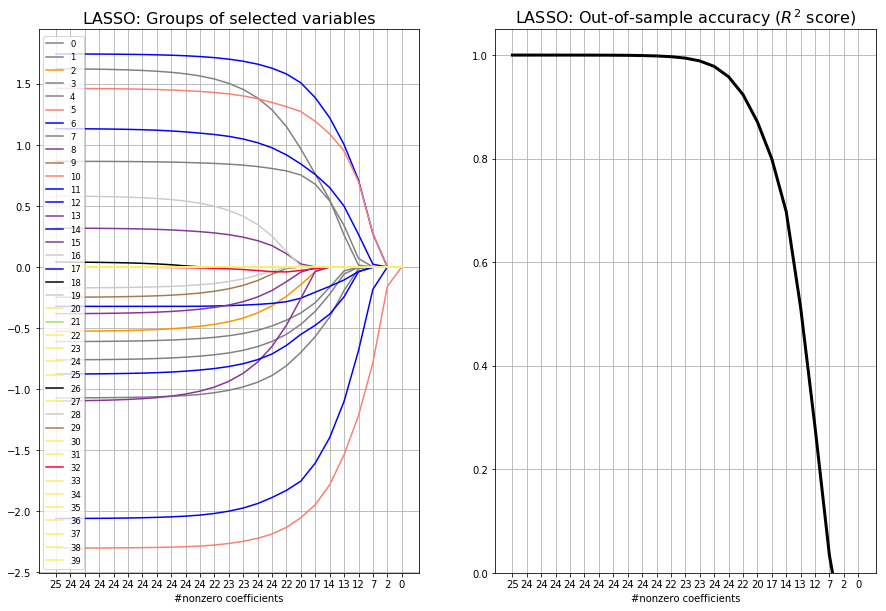

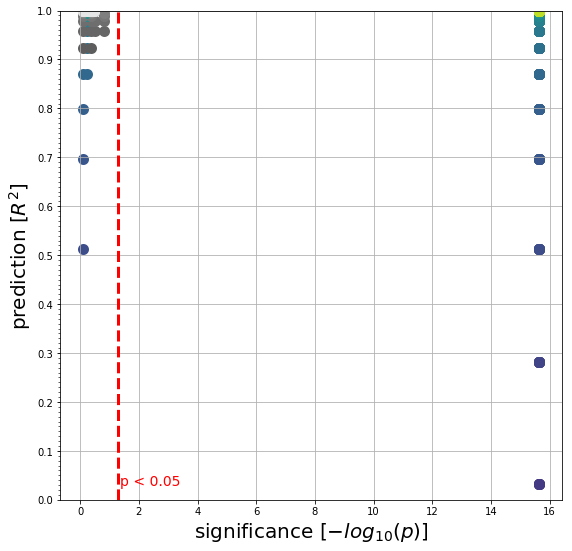

In [103]:
comment = "dataset: 20/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 20
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)
C_grid = np.logspace(-3, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 38
alpha: 0.0014 acc: 1.00 active_coefs: 38
alpha: 0.0020 acc: 1.00 active_coefs: 38
alpha: 0.0027 acc: 1.00 active_coefs: 38
alpha: 0.0038 acc: 1.00 active_coefs: 38
alpha: 0.0054 acc: 1.00 active_coefs: 38
alpha: 0.0075 acc: 1.00 active_coefs: 38
alpha: 0.0105 acc: 1.00 active_coefs: 38
alpha: 0.0147 acc: 1.00 active_coefs: 38
alpha: 0.0205 acc: 1.00 active_coefs: 38
alpha: 0.0287 acc: 0.99 active_coefs: 38
alpha: 0.0402 acc: 0.99 active_coefs: 38
alpha: 0.0562 acc: 0.97 active_coefs: 38
alpha: 0.0787 acc: 0.95 active_coefs: 38
alpha: 0.1101 acc: 0.91 active_coefs: 37
alpha: 0.1540 acc: 0.83 active_coefs: 35
alpha: 0.2154 acc: 0.69 active_coefs: 35
alpha: 0.3014 acc: 0.50 active_coefs: 34
alpha: 0.4217 acc: 0.23 active_coefs: 28
alpha: 0.5900 acc: -0.25 active_coefs: 23
alpha: 0.8254 acc: -0.74 active_coefs: 20
alpha: 1.1548 acc: -0.97 active_coefs: 17
alpha: 1.6156 acc: -1.18 active_coefs: 9
alpha: 2.2603 acc: -1.40 active_coefs: 2
alpha: 3.1623

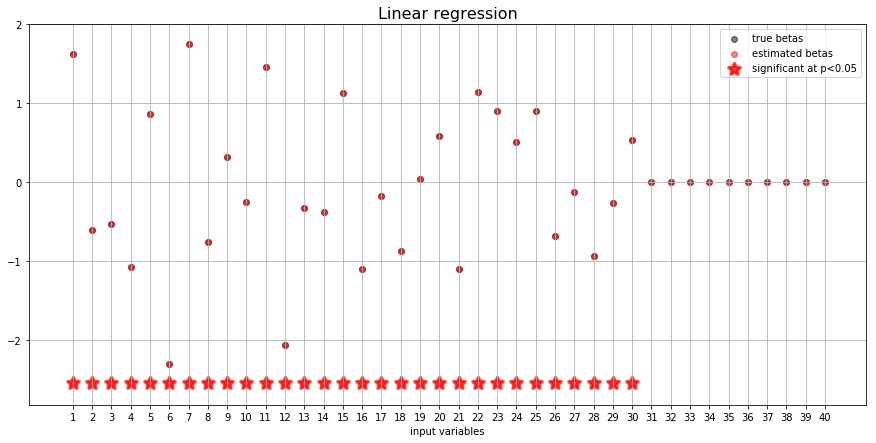

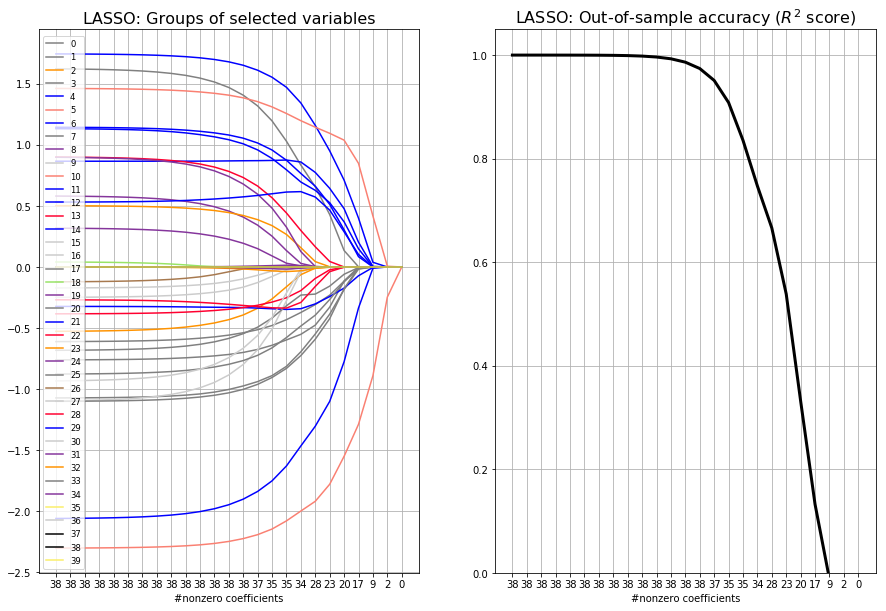

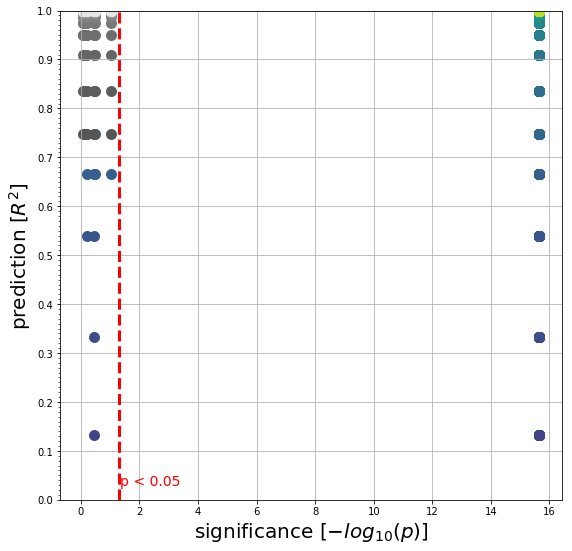

In [104]:
comment = "dataset: 30/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 30
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)
C_grid = np.logspace(-3, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 40
alpha: 0.0014 acc: 1.00 active_coefs: 40
alpha: 0.0020 acc: 1.00 active_coefs: 40
alpha: 0.0027 acc: 1.00 active_coefs: 40
alpha: 0.0038 acc: 1.00 active_coefs: 40
alpha: 0.0054 acc: 1.00 active_coefs: 40
alpha: 0.0075 acc: 1.00 active_coefs: 40
alpha: 0.0105 acc: 1.00 active_coefs: 40
alpha: 0.0147 acc: 1.00 active_coefs: 40
alpha: 0.0205 acc: 1.00 active_coefs: 40
alpha: 0.0287 acc: 0.99 active_coefs: 40
alpha: 0.0402 acc: 0.98 active_coefs: 40
alpha: 0.0562 acc: 0.97 active_coefs: 40
alpha: 0.0787 acc: 0.94 active_coefs: 40
alpha: 0.1101 acc: 0.88 active_coefs: 40
alpha: 0.1540 acc: 0.81 active_coefs: 40
alpha: 0.2154 acc: 0.68 active_coefs: 38
alpha: 0.3014 acc: 0.53 active_coefs: 37
alpha: 0.4217 acc: 0.37 active_coefs: 35
alpha: 0.5900 acc: 0.13 active_coefs: 31
alpha: 0.8254 acc: -0.17 active_coefs: 27
alpha: 1.1548 acc: -0.21 active_coefs: 23
alpha: 1.6156 acc: -0.30 active_coefs: 11
alpha: 2.2603 acc: -0.51 active_coefs: 3
alpha: 3.1623

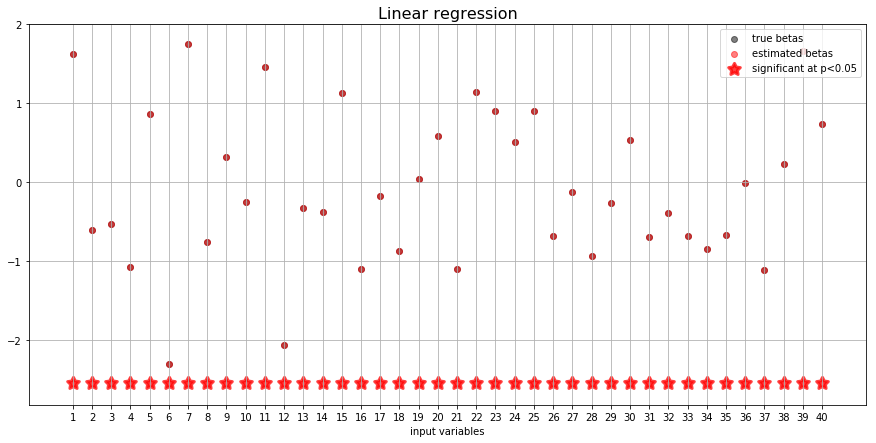

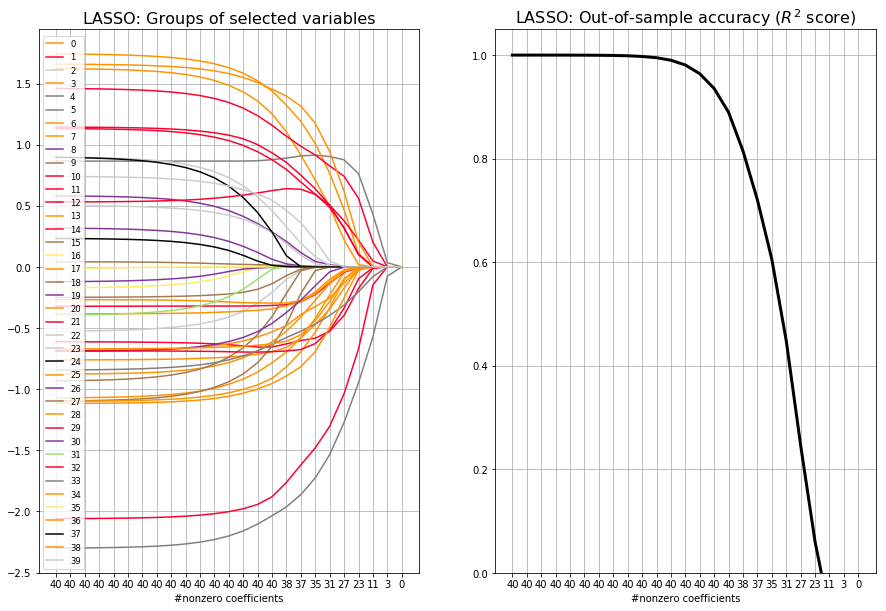

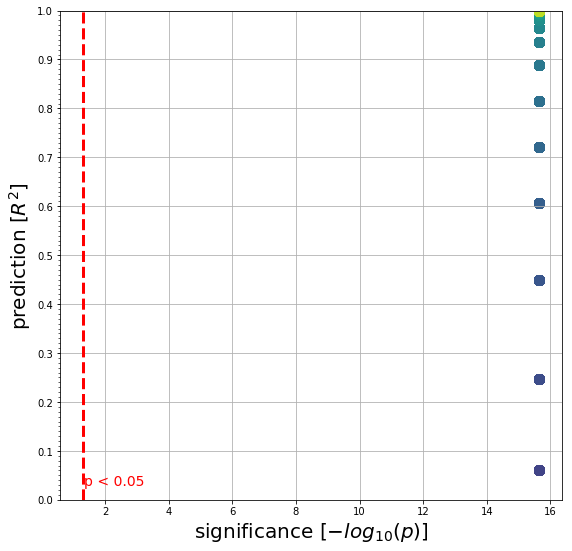

In [105]:
comment = "dataset: 40/40 variables relevant, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 40
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)
C_grid = np.logspace(-3, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

# __Pathological cases with diverging ground-truth model (abs, log, exp, sqrt, 1/x): 1000 samples, 40 variables, error = N(0,1)__

alpha: 0.0562 acc: 0.47 active_coefs: 38
alpha: 0.0649 acc: 0.47 active_coefs: 38
alpha: 0.0750 acc: 0.47 active_coefs: 32
alpha: 0.0866 acc: 0.48 active_coefs: 28
alpha: 0.1000 acc: 0.48 active_coefs: 20
alpha: 0.1155 acc: 0.48 active_coefs: 16
alpha: 0.1334 acc: 0.48 active_coefs: 13
alpha: 0.1540 acc: 0.48 active_coefs: 8
alpha: 0.1778 acc: 0.48 active_coefs: 7
alpha: 0.2054 acc: 0.47 active_coefs: 5
alpha: 0.2371 acc: 0.47 active_coefs: 4
alpha: 0.2738 acc: 0.46 active_coefs: 4
alpha: 0.3162 acc: 0.45 active_coefs: 4
alpha: 0.3652 acc: 0.43 active_coefs: 4
alpha: 0.4217 acc: 0.41 active_coefs: 4
alpha: 0.4870 acc: 0.37 active_coefs: 4
alpha: 0.5623 acc: 0.33 active_coefs: 4
alpha: 0.6494 acc: 0.30 active_coefs: 4
alpha: 0.7499 acc: 0.27 active_coefs: 2
alpha: 0.8660 acc: 0.23 active_coefs: 2
alpha: 1.0000 acc: 0.18 active_coefs: 1
alpha: 1.1548 acc: 0.13 active_coefs: 1
alpha: 1.3335 acc: 0.05 active_coefs: 1
alpha: 1.5399 acc: -0.04 active_coefs: 1
alpha: 1.7783 acc: -0.04 active_

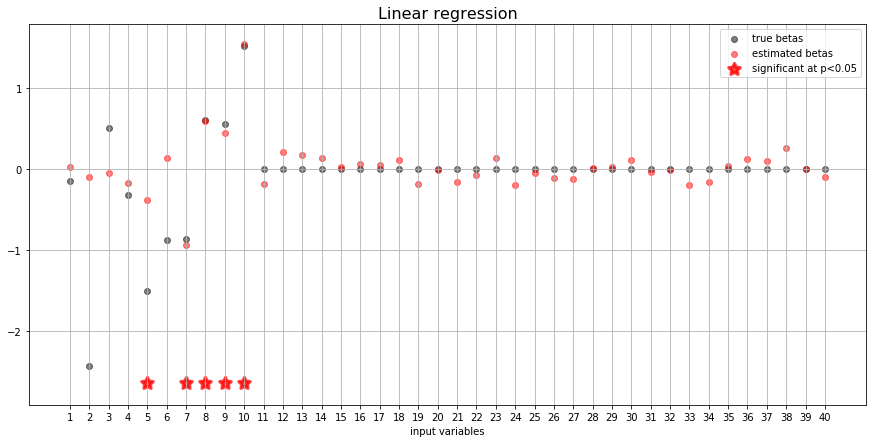

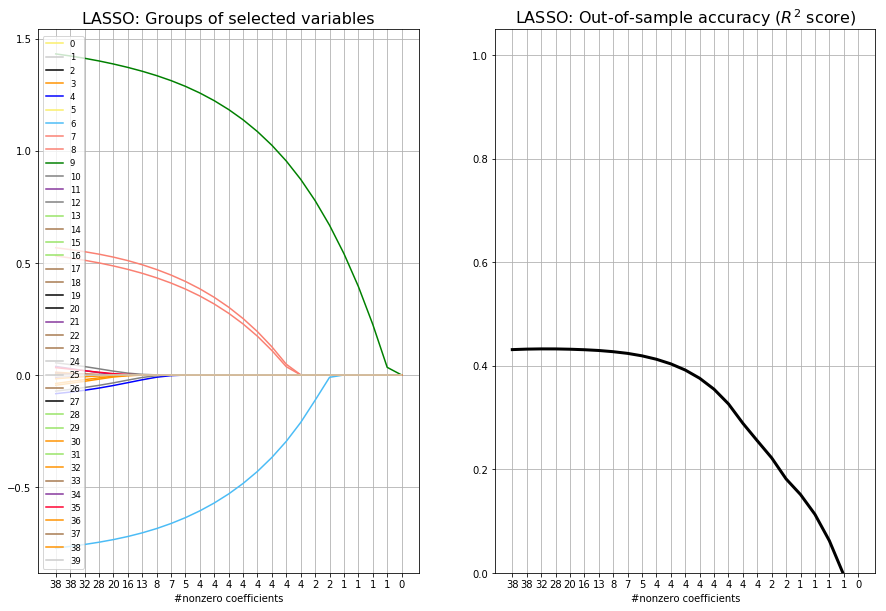

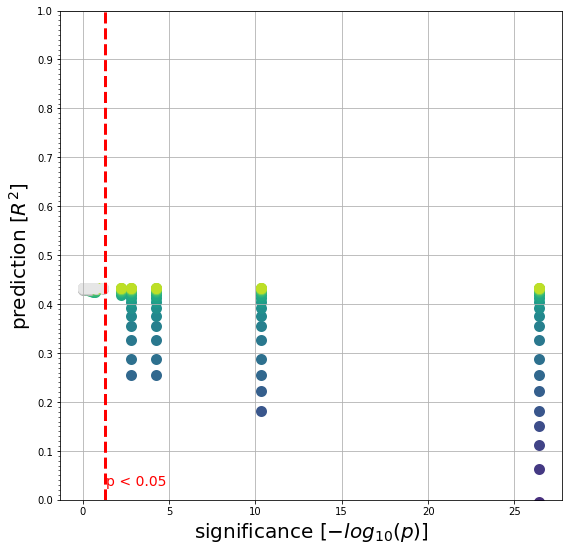

In [106]:
comment = "abs / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_abs5 = X.copy()
X_abs5[:, 0:6] = np.abs(X_abs5[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_abs5).sum(axis=1) + epsilon
C_grid = np.logspace(-1.25, 0.25, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [17]:
### observation: 1/5 path. variables are significant, the same 1/5 path. (?) variables are selected as predictive

alpha: 0.0100 acc: 0.88 active_coefs: 40
alpha: 0.0127 acc: 0.88 active_coefs: 40
alpha: 0.0162 acc: 0.88 active_coefs: 40
alpha: 0.0205 acc: 0.88 active_coefs: 40
alpha: 0.0261 acc: 0.88 active_coefs: 40
alpha: 0.0332 acc: 0.88 active_coefs: 39
alpha: 0.0422 acc: 0.88 active_coefs: 35
alpha: 0.0536 acc: 0.88 active_coefs: 29
alpha: 0.0681 acc: 0.88 active_coefs: 19
alpha: 0.0866 acc: 0.88 active_coefs: 16
alpha: 0.1101 acc: 0.87 active_coefs: 12
alpha: 0.1399 acc: 0.87 active_coefs: 10
alpha: 0.1778 acc: 0.86 active_coefs: 10
alpha: 0.2260 acc: 0.84 active_coefs: 8
alpha: 0.2873 acc: 0.82 active_coefs: 8
alpha: 0.3652 acc: 0.79 active_coefs: 8
alpha: 0.4642 acc: 0.74 active_coefs: 7
alpha: 0.5900 acc: 0.67 active_coefs: 7
alpha: 0.7499 acc: 0.58 active_coefs: 4
alpha: 0.9532 acc: 0.46 active_coefs: 4
alpha: 1.2115 acc: 0.28 active_coefs: 3
alpha: 1.5399 acc: 0.12 active_coefs: 2
alpha: 1.9573 acc: 0.00 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 a

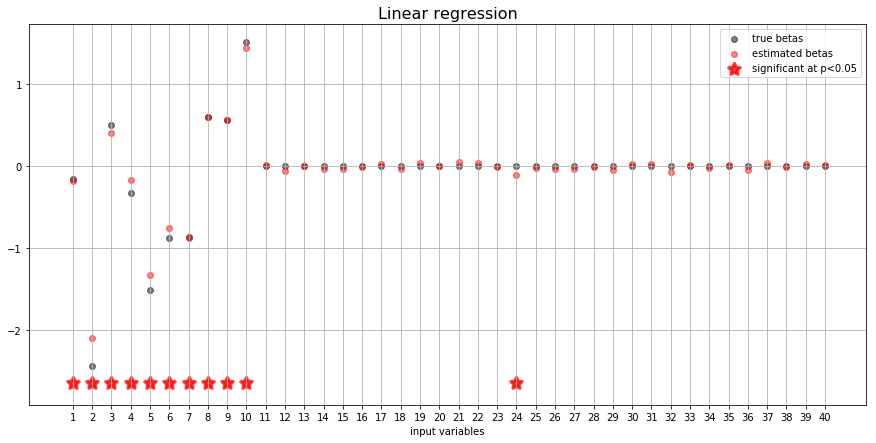

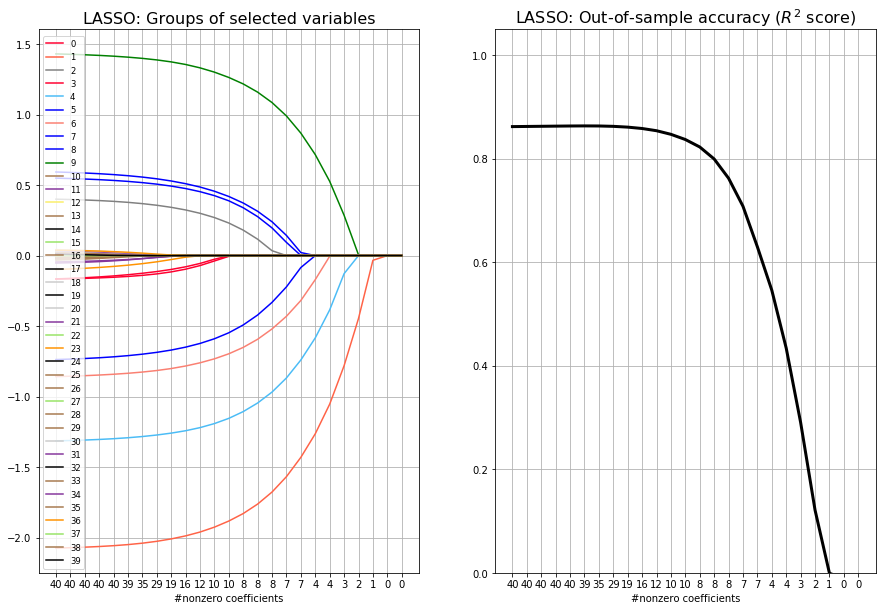

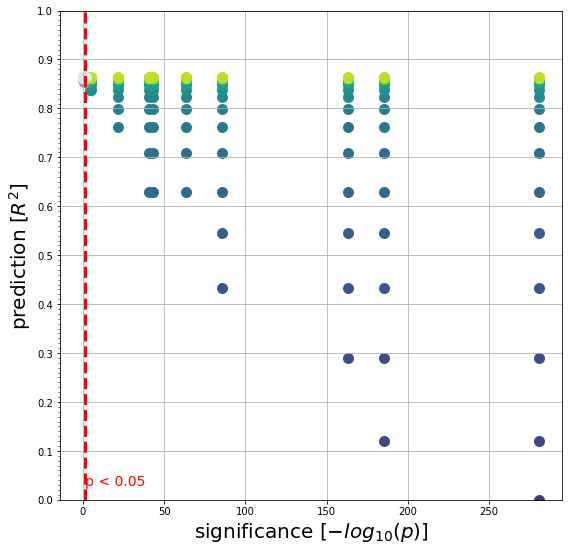

In [107]:
comment = "square root / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_sqrt5 = X.copy()
signs = np.sign(X)
X_sqrt5[:, 0:6] = signs[:, 0:6] * np.sqrt(np.abs(X_sqrt5[:, 0:6]))  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_sqrt5).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [19]:
### observation: 5/5 path. variables are significant, the same 5/5 path. (?) variables are selected as predictive

alpha: 0.0100 acc: 0.13 active_coefs: 40
alpha: 0.0127 acc: 0.13 active_coefs: 40
alpha: 0.0162 acc: 0.13 active_coefs: 40
alpha: 0.0205 acc: 0.13 active_coefs: 40
alpha: 0.0261 acc: 0.13 active_coefs: 40
alpha: 0.0332 acc: 0.13 active_coefs: 40
alpha: 0.0422 acc: 0.13 active_coefs: 40
alpha: 0.0536 acc: 0.14 active_coefs: 40
alpha: 0.0681 acc: 0.14 active_coefs: 40
alpha: 0.0866 acc: 0.14 active_coefs: 40
alpha: 0.1101 acc: 0.14 active_coefs: 40
alpha: 0.1399 acc: 0.15 active_coefs: 38
alpha: 0.1778 acc: 0.16 active_coefs: 29
alpha: 0.2260 acc: 0.15 active_coefs: 16
alpha: 0.2873 acc: 0.15 active_coefs: 13
alpha: 0.3652 acc: 0.15 active_coefs: 8
alpha: 0.4642 acc: 0.14 active_coefs: 5
alpha: 0.5900 acc: 0.13 active_coefs: 4
alpha: 0.7499 acc: 0.12 active_coefs: 3
alpha: 0.9532 acc: 0.09 active_coefs: 2
alpha: 1.2115 acc: 0.06 active_coefs: 1
alpha: 1.5399 acc: 0.01 active_coefs: 1
alpha: 1.9573 acc: -0.00 active_coefs: 0
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.0

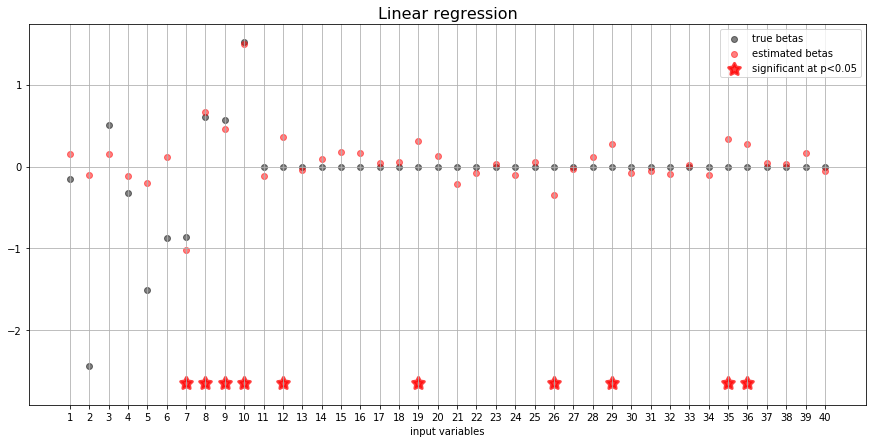

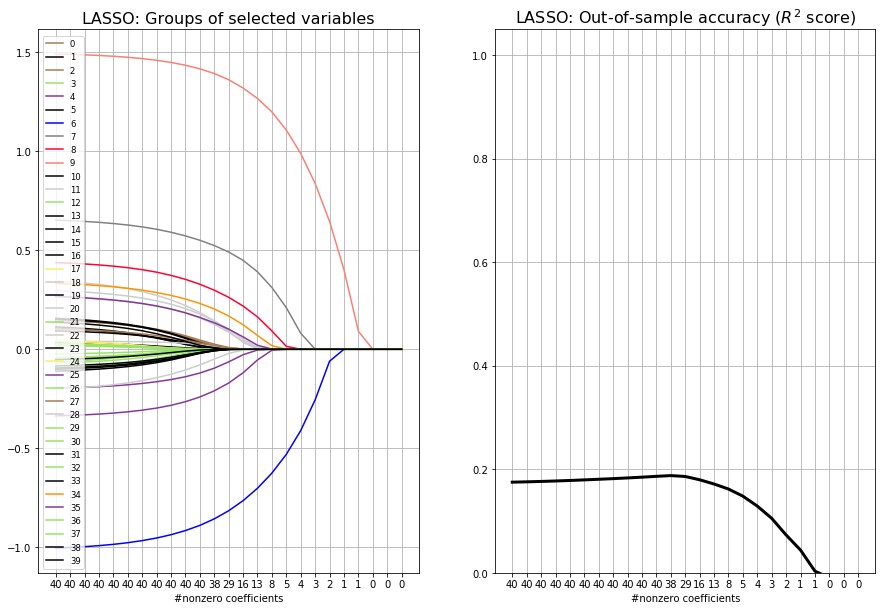

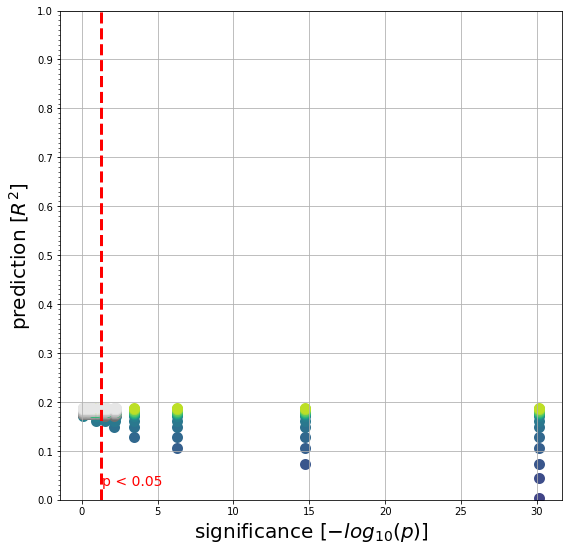

In [108]:
comment = "logn / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_log5 = X.copy()
signs = np.sign(X)
# Bertrand: no sign update
# Bertrand: rather log (X + constant); such as constant=4
X_log5[:, 0:6] = signs[:, 0:6] * np.log(np.abs(X_log5[:, 0:6]))  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_log5).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 0.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 0/5 path. variables are significant, the same 1/5 path. variables are selected as predictive -> 

alpha: 0.0010 acc: 0.70 active_coefs: 40
alpha: 0.0015 acc: 0.70 active_coefs: 40
alpha: 0.0022 acc: 0.70 active_coefs: 40
alpha: 0.0032 acc: 0.70 active_coefs: 40
alpha: 0.0046 acc: 0.70 active_coefs: 40
alpha: 0.0068 acc: 0.70 active_coefs: 40
alpha: 0.0100 acc: 0.70 active_coefs: 40
alpha: 0.0147 acc: 0.70 active_coefs: 40
alpha: 0.0215 acc: 0.70 active_coefs: 40
alpha: 0.0316 acc: 0.70 active_coefs: 40
alpha: 0.0464 acc: 0.71 active_coefs: 40
alpha: 0.0681 acc: 0.71 active_coefs: 40
alpha: 0.1000 acc: 0.71 active_coefs: 40
alpha: 0.1468 acc: 0.71 active_coefs: 37
alpha: 0.2154 acc: 0.72 active_coefs: 25
alpha: 0.3162 acc: 0.72 active_coefs: 15
alpha: 0.4642 acc: 0.71 active_coefs: 9
alpha: 0.6813 acc: 0.67 active_coefs: 8
alpha: 1.0000 acc: 0.62 active_coefs: 4
alpha: 1.4678 acc: 0.51 active_coefs: 4
alpha: 2.1544 acc: 0.39 active_coefs: 2
alpha: 3.1623 acc: 0.17 active_coefs: 2
alpha: 4.6416 acc: -0.00 active_coefs: 0
alpha: 6.8129 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0

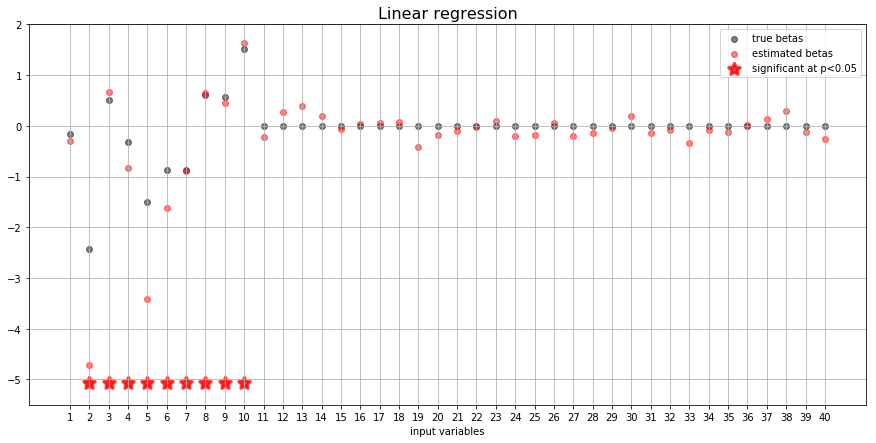

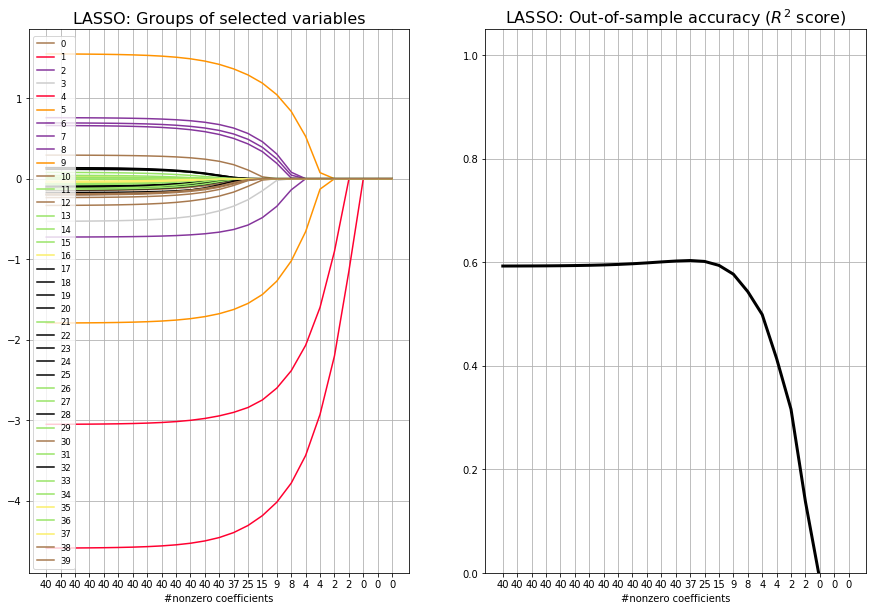

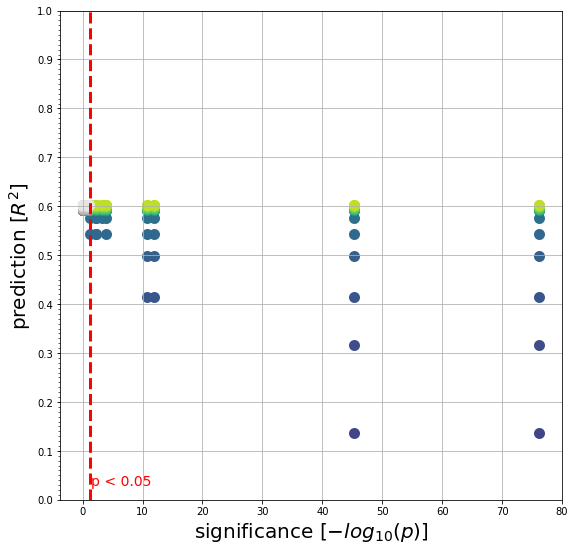

In [109]:
comment = "exp / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise only monotone transformation"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_exp = X.copy()
signs = np.sign(X)
X_exp[:, 0:6] = signs[:, 0:6] * np.exp(X_exp[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_exp).sum(axis=1) + epsilon
C_grid = np.logspace(-3, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0010 acc: -1.25 active_coefs: 40
alpha: 0.0015 acc: -1.06 active_coefs: 40
alpha: 0.0022 acc: -0.80 active_coefs: 40
alpha: 0.0032 acc: -0.47 active_coefs: 40
alpha: 0.0046 acc: -0.07 active_coefs: 40
alpha: 0.0068 acc: 0.24 active_coefs: 40
alpha: 0.0100 acc: 0.37 active_coefs: 40
alpha: 0.0147 acc: 0.47 active_coefs: 40
alpha: 0.0215 acc: 0.51 active_coefs: 40
alpha: 0.0316 acc: 0.52 active_coefs: 40
alpha: 0.0464 acc: 0.46 active_coefs: 39
alpha: 0.0681 acc: 0.45 active_coefs: 37
alpha: 0.1000 acc: 0.49 active_coefs: 32
alpha: 0.1468 acc: 0.48 active_coefs: 21
alpha: 0.2154 acc: 0.46 active_coefs: 12
alpha: 0.3162 acc: 0.43 active_coefs: 3
alpha: 0.4642 acc: 0.35 active_coefs: 1
alpha: 0.6813 acc: 0.23 active_coefs: 1
alpha: 1.0000 acc: 0.02 active_coefs: 1
alpha: 1.4678 acc: -0.02 active_coefs: 0
alpha: 2.1544 acc: -0.02 active_coefs: 0
alpha: 3.1623 acc: -0.02 active_coefs: 0
alpha: 4.6416 acc: -0.02 active_coefs: 0
alpha: 6.8129 acc: -0.02 active_coefs: 0
alpha: 10.0000 

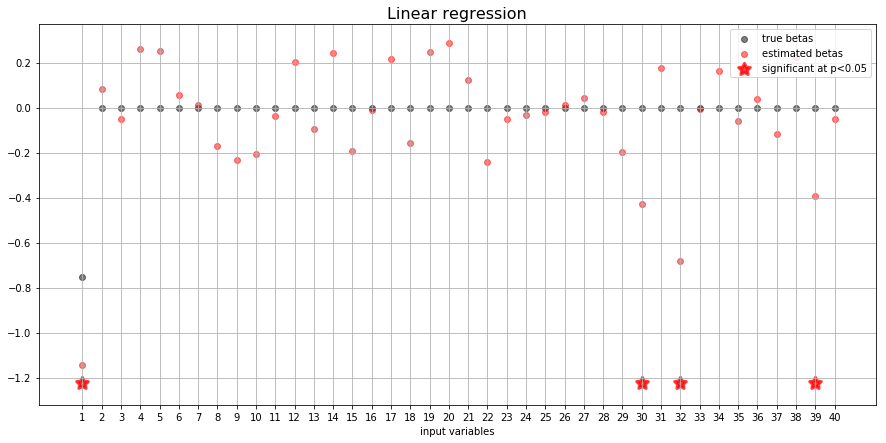

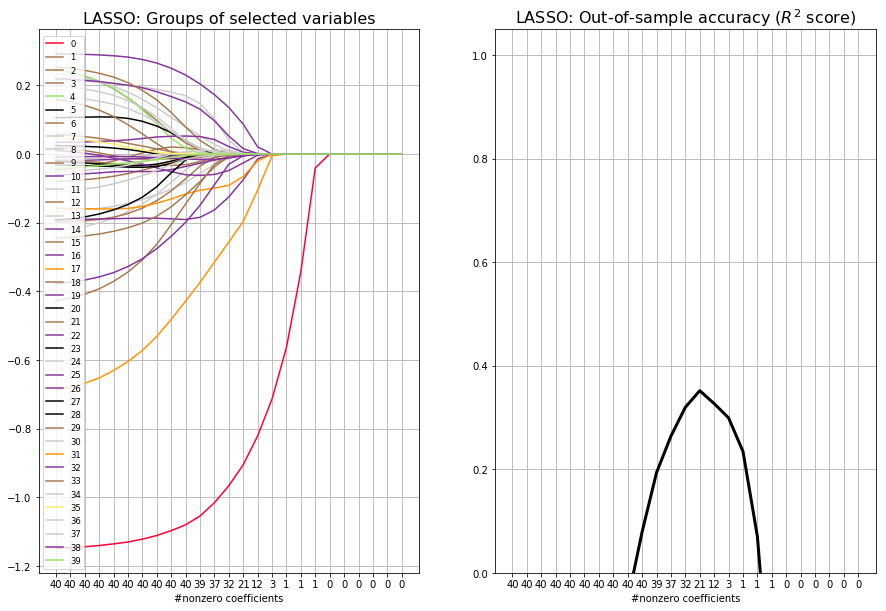

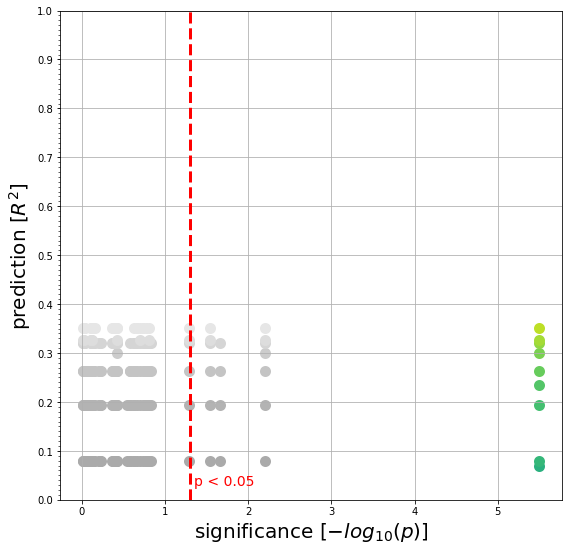

In [110]:
comment = "dataset: 1/40 relevant variables linear ground truth + some noise"
rs = np.random.RandomState(1)
n_samples = 60
n_feat = 40
n_feat_relevant = 1
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_exp = X.copy()
signs = np.sign(X)
y = (true_coefs * X).sum(axis=1) + epsilon * 1
C_grid = np.logspace(-3, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

alpha: 0.0010 acc: -3.11 active_coefs: 40
alpha: 0.0015 acc: -2.76 active_coefs: 40
alpha: 0.0022 acc: -2.29 active_coefs: 40
alpha: 0.0032 acc: -1.68 active_coefs: 40
alpha: 0.0046 acc: -0.95 active_coefs: 40
alpha: 0.0068 acc: -0.39 active_coefs: 40
alpha: 0.0100 acc: -0.16 active_coefs: 40
alpha: 0.0147 acc: 0.03 active_coefs: 40
alpha: 0.0215 acc: 0.11 active_coefs: 40
alpha: 0.0316 acc: 0.12 active_coefs: 40
alpha: 0.0464 acc: 0.01 active_coefs: 39
alpha: 0.0681 acc: -0.01 active_coefs: 37
alpha: 0.1000 acc: 0.06 active_coefs: 32
alpha: 0.1468 acc: 0.06 active_coefs: 21
alpha: 0.2154 acc: 0.02 active_coefs: 13
alpha: 0.3162 acc: -0.00 active_coefs: 3
alpha: 0.4642 acc: -0.00 active_coefs: 0
alpha: 0.6813 acc: -0.00 active_coefs: 0
alpha: 1.0000 acc: -0.00 active_coefs: 0
alpha: 1.4678 acc: -0.00 active_coefs: 0
alpha: 2.1544 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 active_coefs: 0
alpha: 4.6416 acc: -0.00 active_coefs: 0
alpha: 6.8129 acc: -0.00 active_coefs: 0
alpha: 1

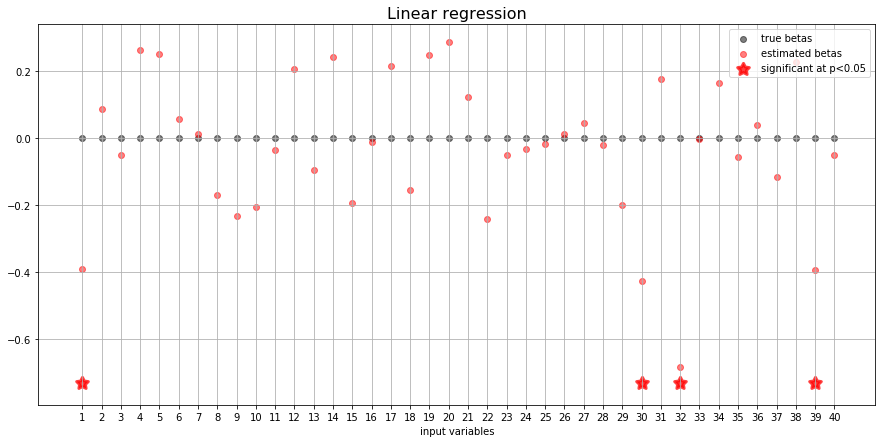

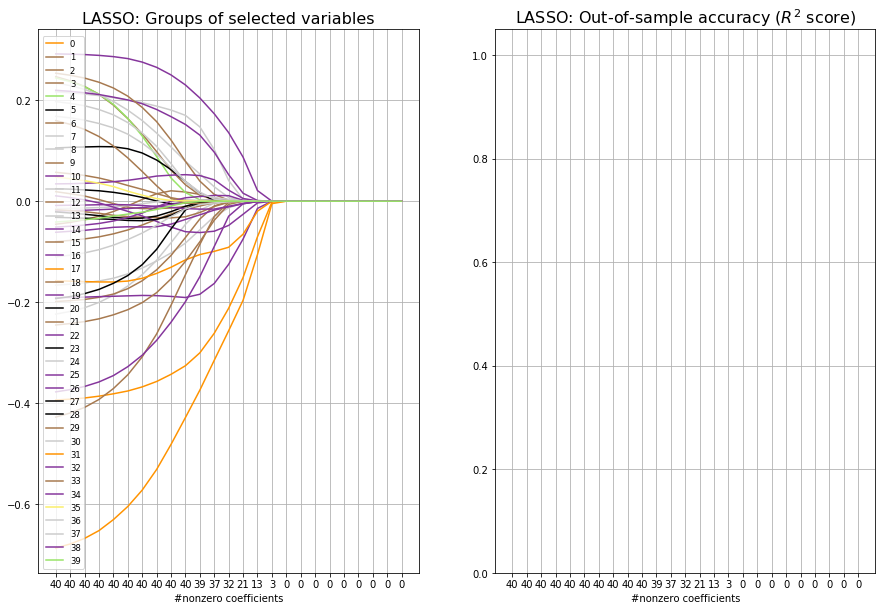

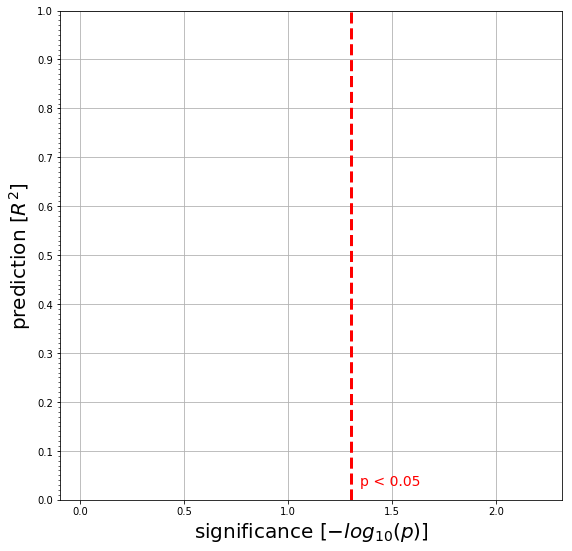

In [111]:
comment = "dataset: 0/40 relevant variables linear ground truth + some noise"
rs = np.random.RandomState(1)
n_samples = 60
n_feat = 40
n_feat_relevant = 0
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_exp = X.copy()
signs = np.sign(X)
y = (true_coefs * X).sum(axis=1) + epsilon * 1
C_grid = np.logspace(-3, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 4/5 path. variables are significant, the ?/5 path. variables are selected as predictive

alpha: 0.0100 acc: -0.13 active_coefs: 40
alpha: 0.0140 acc: -0.13 active_coefs: 40
alpha: 0.0196 acc: -0.13 active_coefs: 40
alpha: 0.0274 acc: -0.13 active_coefs: 40
alpha: 0.0383 acc: -0.13 active_coefs: 40
alpha: 0.0536 acc: -0.13 active_coefs: 40
alpha: 0.0750 acc: -0.13 active_coefs: 40
alpha: 0.1049 acc: -0.13 active_coefs: 40
alpha: 0.1468 acc: -0.13 active_coefs: 40
alpha: 0.2054 acc: -0.13 active_coefs: 40
alpha: 0.2873 acc: -0.12 active_coefs: 40
alpha: 0.4019 acc: -0.12 active_coefs: 40
alpha: 0.5623 acc: -0.12 active_coefs: 40
alpha: 0.7867 acc: -0.11 active_coefs: 40
alpha: 1.1007 acc: -0.11 active_coefs: 40
alpha: 1.5399 acc: -0.10 active_coefs: 40
alpha: 2.1544 acc: -0.09 active_coefs: 40
alpha: 3.0142 acc: -0.08 active_coefs: 40
alpha: 4.2170 acc: -0.06 active_coefs: 33
alpha: 5.8997 acc: -0.05 active_coefs: 28
alpha: 8.2540 acc: -0.04 active_coefs: 16
alpha: 11.5478 acc: -0.02 active_coefs: 7
alpha: 16.1560 acc: -0.02 active_coefs: 0
alpha: 22.6030 acc: -0.02 active_c

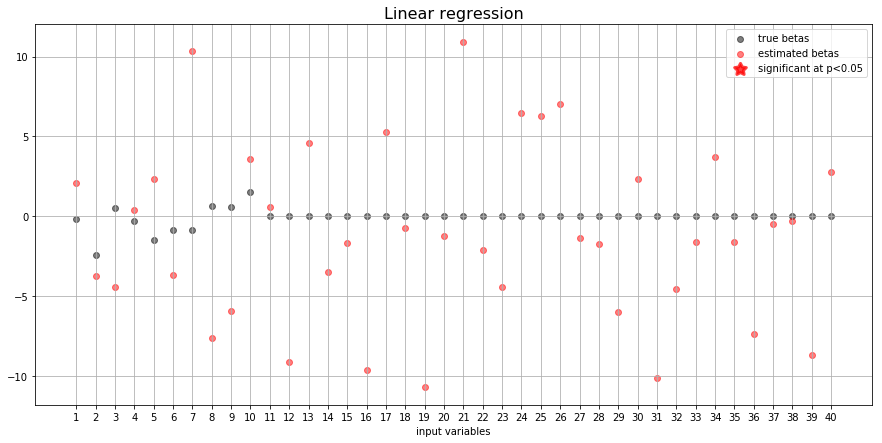

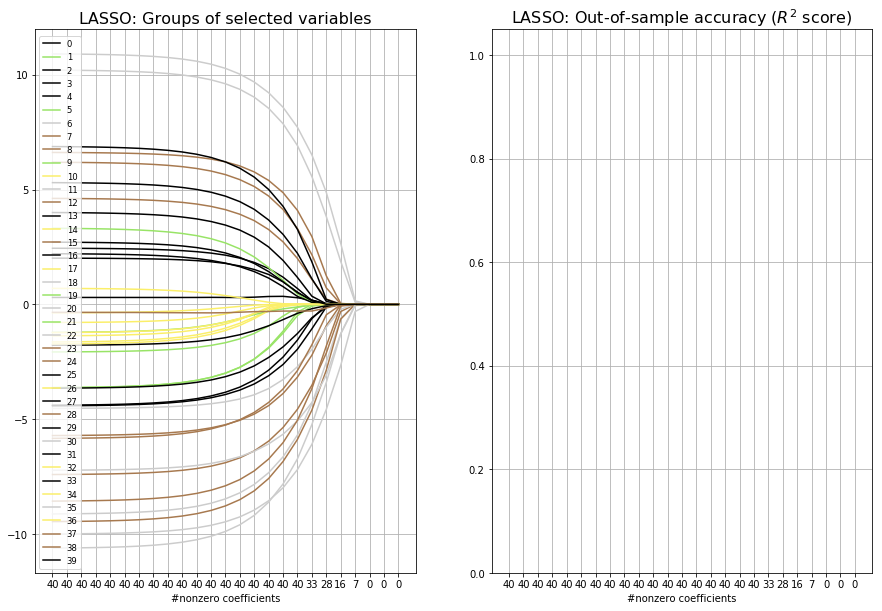

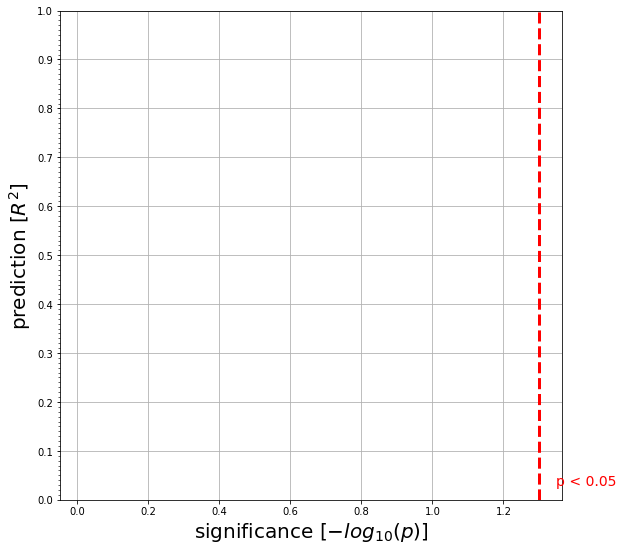

In [112]:
comment = "1/x / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise opposite effect of log roughly; small values become gigantic"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_inv = X.copy()
X_inv[:, 0:6] = 1. / X_inv[:, 0:6]  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_inv).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 0/5 path. variables are significant, the 0/5 path. variables are selected as predictive -> B: un peu extreme

# __Polynomial transformations 1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.10 active_coefs: 40
alpha: 0.0140 acc: 0.10 active_coefs: 40
alpha: 0.0196 acc: 0.10 active_coefs: 40
alpha: 0.0274 acc: 0.11 active_coefs: 40
alpha: 0.0383 acc: 0.11 active_coefs: 40
alpha: 0.0536 acc: 0.12 active_coefs: 40
alpha: 0.0750 acc: 0.12 active_coefs: 40
alpha: 0.1049 acc: 0.13 active_coefs: 40
alpha: 0.1468 acc: 0.14 active_coefs: 35
alpha: 0.2054 acc: 0.14 active_coefs: 21
alpha: 0.2873 acc: 0.15 active_coefs: 10
alpha: 0.4019 acc: 0.15 active_coefs: 7
alpha: 0.5623 acc: 0.13 active_coefs: 4
alpha: 0.7867 acc: 0.10 active_coefs: 2
alpha: 1.1007 acc: 0.05 active_coefs: 1
alpha: 1.5399 acc: -0.03 active_coefs: 1
alpha: 2.1544 acc: -0.03 active_coefs: 0
alpha: 3.0142 acc: -0.03 active_coefs: 0
alpha: 4.2170 acc: -0.03 active_coefs: 0
alpha: 5.8997 acc: -0.03 active_coefs: 0
alpha: 8.2540 acc: -0.03 active_coefs: 0
alpha: 11.5478 acc: -0.03 active_coefs: 0
alpha: 16.1560 acc: -0.03 active_coefs: 0
alpha: 22.6030 acc: -0.03 active_coefs: 0
alpha: 31.6228 ac

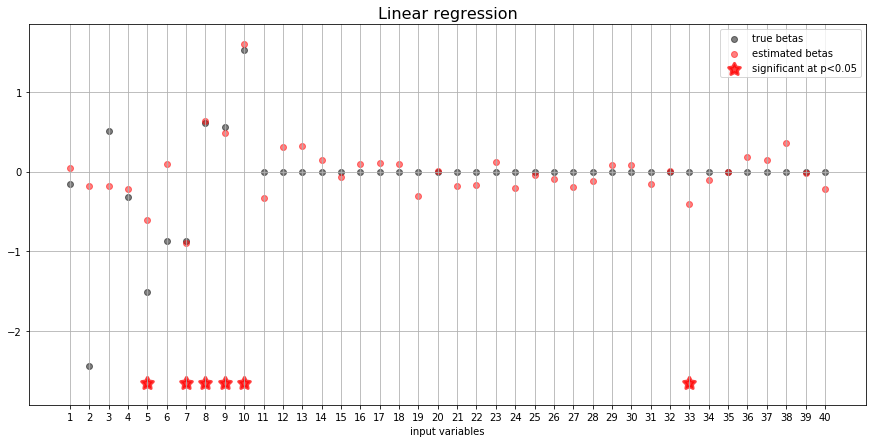

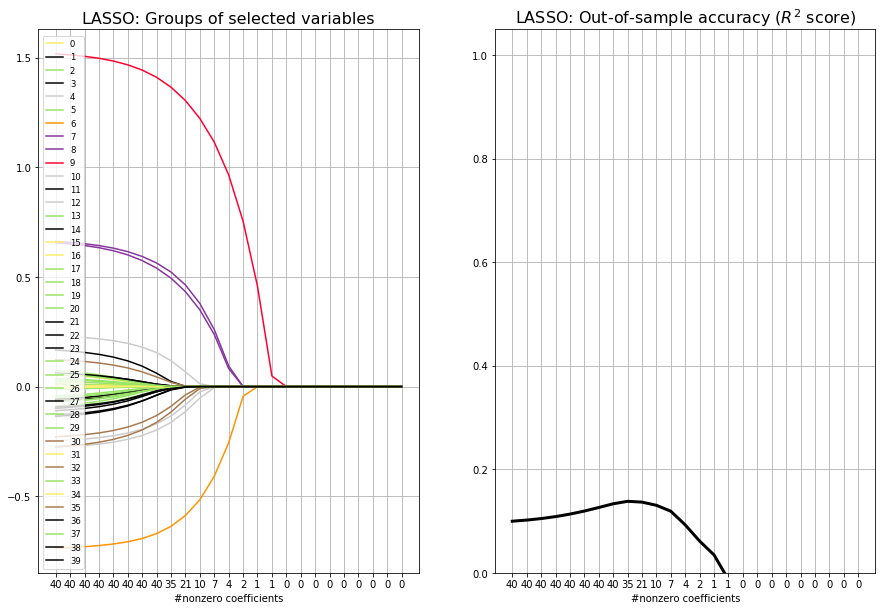

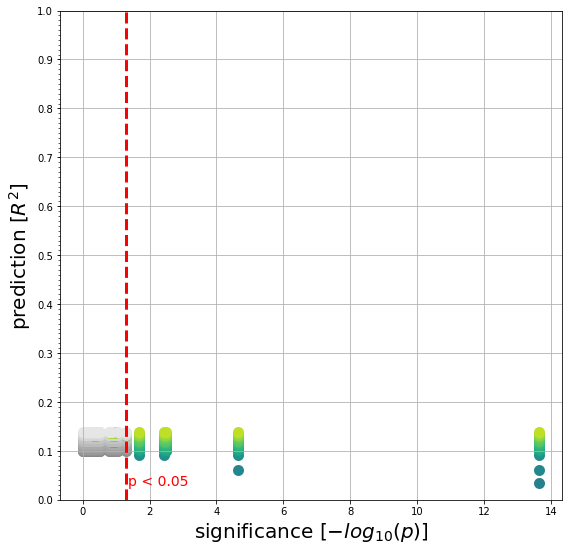

In [113]:
comment = "x^2 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise cube -> keep monotony; otherwise not -> "
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_2 = X.copy()
X_2[:, 0:6] = np.square(X_2[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_2).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 1/5 path. variables are significant, the same 1/5 path. variables are selected as predictive

alpha: 0.0100 acc: 0.70 active_coefs: 40
alpha: 0.0140 acc: 0.70 active_coefs: 40
alpha: 0.0196 acc: 0.70 active_coefs: 40
alpha: 0.0274 acc: 0.70 active_coefs: 40
alpha: 0.0383 acc: 0.70 active_coefs: 40
alpha: 0.0536 acc: 0.70 active_coefs: 40
alpha: 0.0750 acc: 0.71 active_coefs: 40
alpha: 0.1049 acc: 0.71 active_coefs: 40
alpha: 0.1468 acc: 0.71 active_coefs: 40
alpha: 0.2054 acc: 0.71 active_coefs: 37
alpha: 0.2873 acc: 0.71 active_coefs: 33
alpha: 0.4019 acc: 0.71 active_coefs: 24
alpha: 0.5623 acc: 0.70 active_coefs: 12
alpha: 0.7867 acc: 0.68 active_coefs: 8
alpha: 1.1007 acc: 0.64 active_coefs: 7
alpha: 1.5399 acc: 0.57 active_coefs: 4
alpha: 2.1544 acc: 0.50 active_coefs: 3
alpha: 3.0142 acc: 0.41 active_coefs: 2
alpha: 4.2170 acc: 0.23 active_coefs: 2
alpha: 5.8997 acc: 0.08 active_coefs: 1
alpha: 8.2540 acc: -0.00 active_coefs: 0
alpha: 11.5478 acc: -0.00 active_coefs: 0
alpha: 16.1560 acc: -0.00 active_coefs: 0
alpha: 22.6030 acc: -0.00 active_coefs: 0
alpha: 31.6228 acc: 

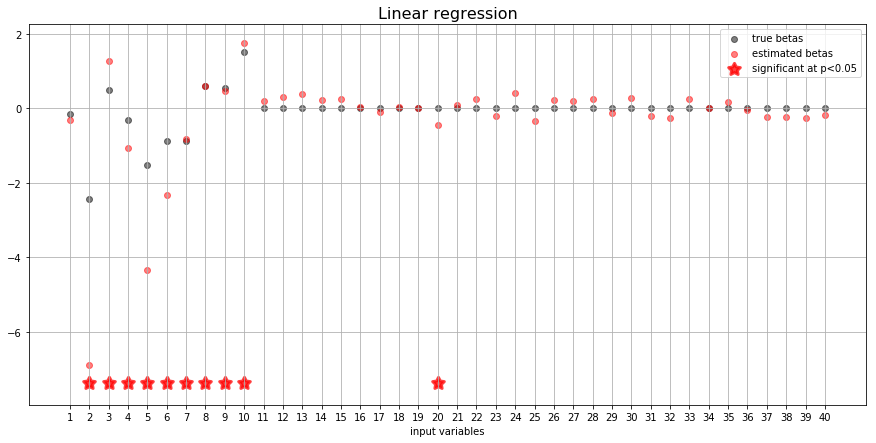

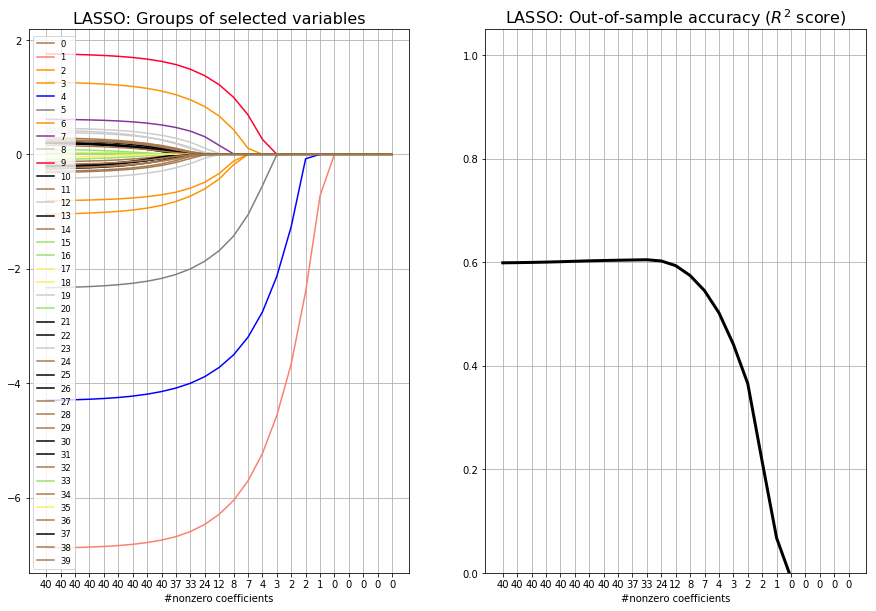

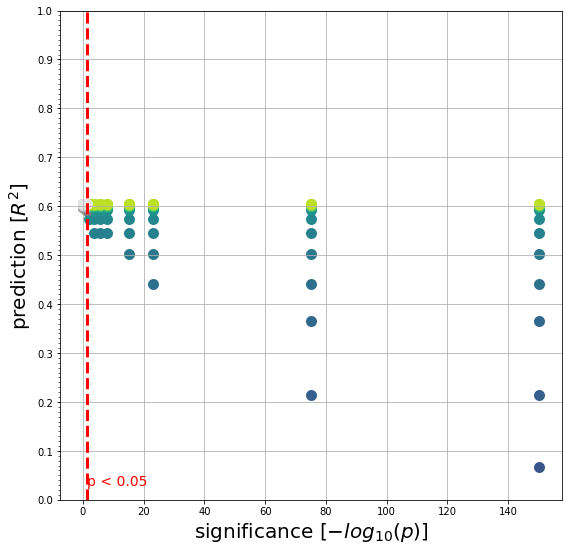

In [114]:
comment = "x^3 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_3 = X.copy()
X_3[:, 0:6] = X_3[:, 0:6]**3  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_3).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1.5, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [25]:
### observation: 4/5 path. variables are significant, the same 4/5 path. variables are selected as predictive

alpha: 0.1000 acc: -0.13 active_coefs: 40
alpha: 0.1212 acc: -0.13 active_coefs: 40
alpha: 0.1468 acc: -0.12 active_coefs: 40
alpha: 0.1778 acc: -0.12 active_coefs: 40
alpha: 0.2154 acc: -0.11 active_coefs: 40
alpha: 0.2610 acc: -0.11 active_coefs: 40
alpha: 0.3162 acc: -0.10 active_coefs: 40
alpha: 0.3831 acc: -0.09 active_coefs: 40
alpha: 0.4642 acc: -0.08 active_coefs: 40
alpha: 0.5623 acc: -0.07 active_coefs: 40
alpha: 0.6813 acc: -0.06 active_coefs: 39
alpha: 0.8254 acc: -0.05 active_coefs: 37
alpha: 1.0000 acc: -0.04 active_coefs: 33
alpha: 1.2115 acc: -0.02 active_coefs: 25
alpha: 1.4678 acc: -0.01 active_coefs: 17
alpha: 1.7783 acc: -0.00 active_coefs: 9
alpha: 2.1544 acc: -0.00 active_coefs: 3
alpha: 2.6102 acc: -0.00 active_coefs: 1
alpha: 3.1623 acc: -0.00 active_coefs: 0
alpha: 3.8312 acc: -0.00 active_coefs: 0
alpha: 4.6416 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 6.8129 acc: -0.00 active_coefs: 0
alpha: 8.2540 acc: -0.00 active_coefs: 0
a

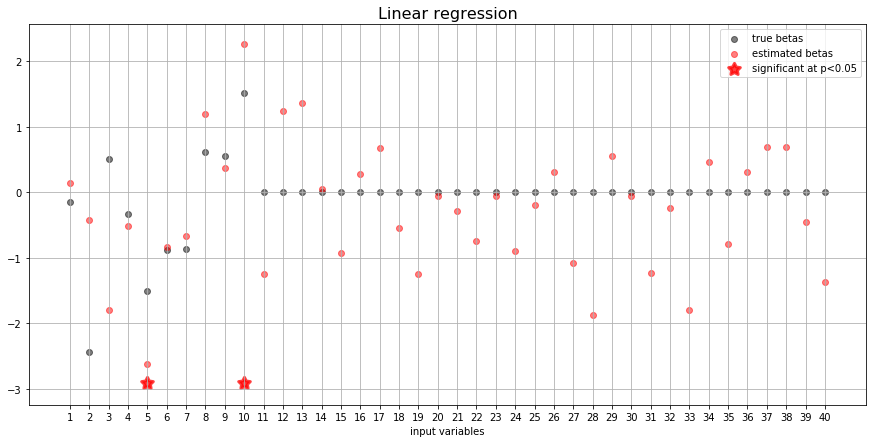

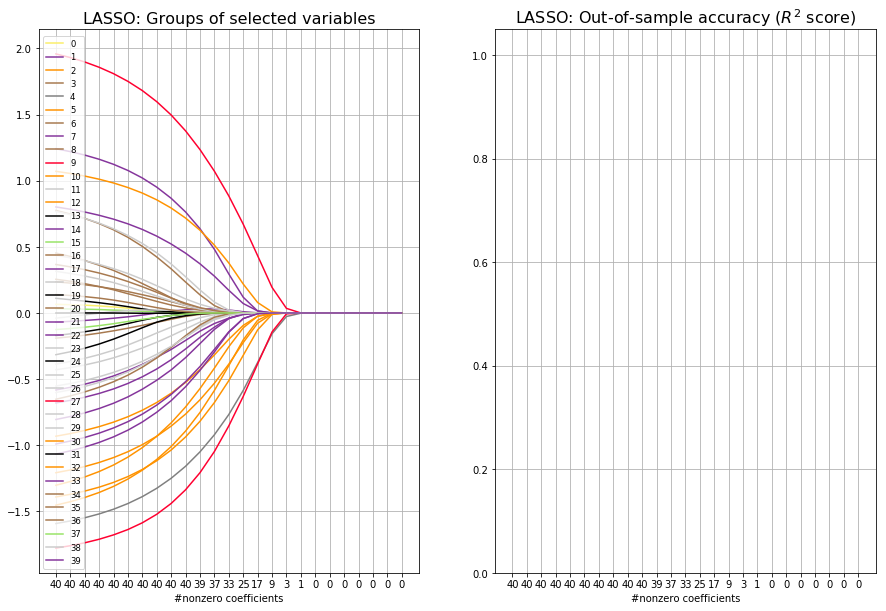

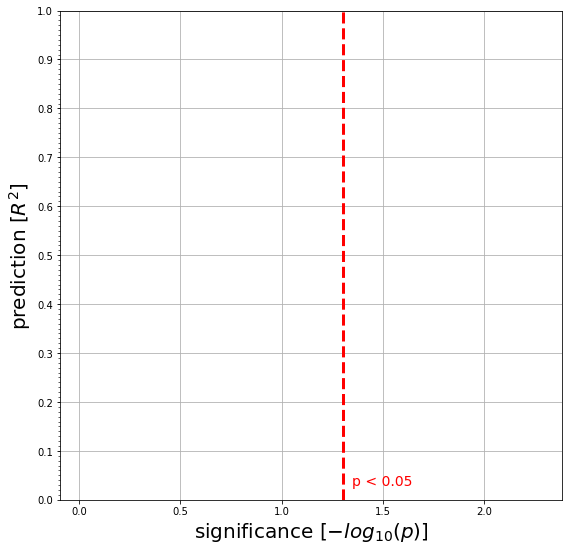

In [115]:
comment = "x^4 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_4 = X.copy()
X_4[:, 0:6] = X_4[:, 0:6]**4  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_4).sum(axis=1) + epsilon
C_grid = np.logspace(-1, 1.0, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 1/5 path. variables are significant, the same 1/5 path. variables are selected as predictive + coefficients for other 4/5 relevant variables are messed up

alpha: 0.1000 acc: 0.28 active_coefs: 40
alpha: 0.1334 acc: 0.28 active_coefs: 40
alpha: 0.1778 acc: 0.29 active_coefs: 40
alpha: 0.2371 acc: 0.29 active_coefs: 40
alpha: 0.3162 acc: 0.29 active_coefs: 40
alpha: 0.4217 acc: 0.30 active_coefs: 40
alpha: 0.5623 acc: 0.30 active_coefs: 40
alpha: 0.7499 acc: 0.31 active_coefs: 40
alpha: 1.0000 acc: 0.31 active_coefs: 40
alpha: 1.3335 acc: 0.32 active_coefs: 40
alpha: 1.7783 acc: 0.33 active_coefs: 36
alpha: 2.3714 acc: 0.34 active_coefs: 33
alpha: 3.1623 acc: 0.35 active_coefs: 25
alpha: 4.2170 acc: 0.35 active_coefs: 11
alpha: 5.6234 acc: 0.33 active_coefs: 6
alpha: 7.4989 acc: 0.30 active_coefs: 3
alpha: 10.0000 acc: 0.26 active_coefs: 3
alpha: 13.3352 acc: 0.22 active_coefs: 2
alpha: 17.7828 acc: 0.15 active_coefs: 2
alpha: 23.7137 acc: 0.10 active_coefs: 1
alpha: 31.6228 acc: -0.00 active_coefs: 1
alpha: 42.1697 acc: -0.00 active_coefs: 0
alpha: 56.2341 acc: -0.00 active_coefs: 0
alpha: 74.9894 acc: -0.00 active_coefs: 0
alpha: 100.000

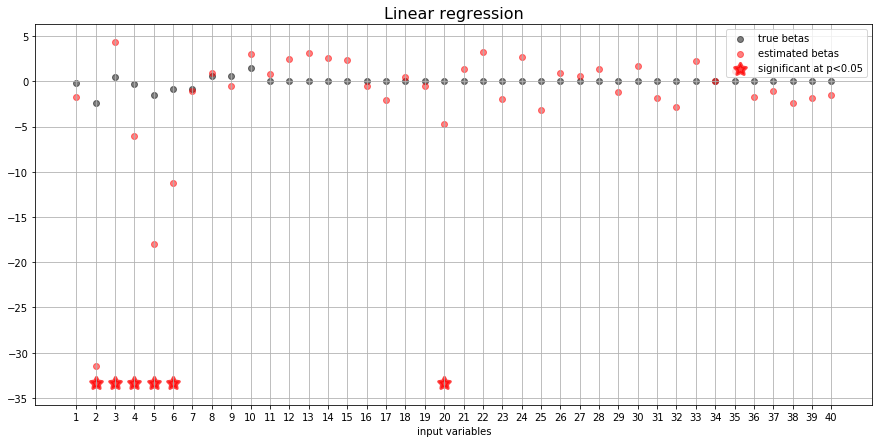

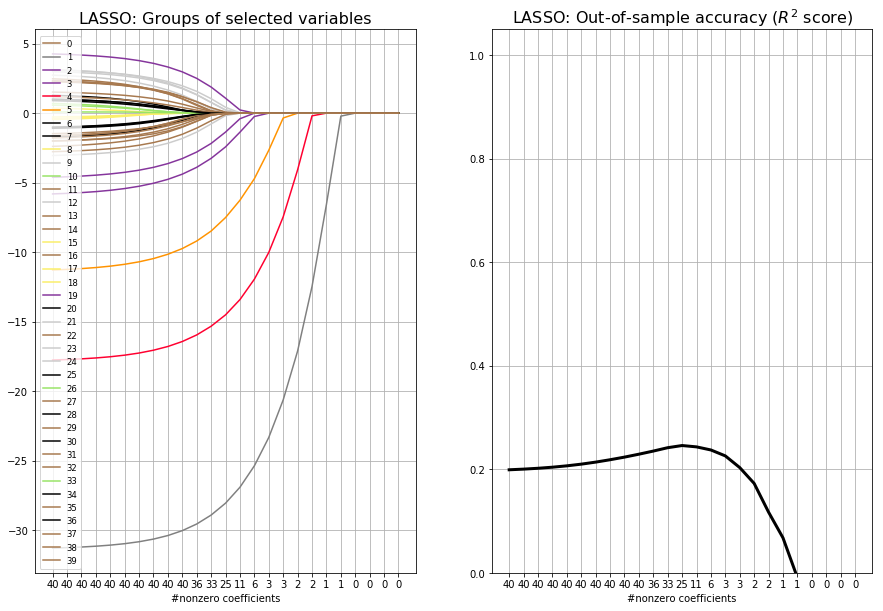

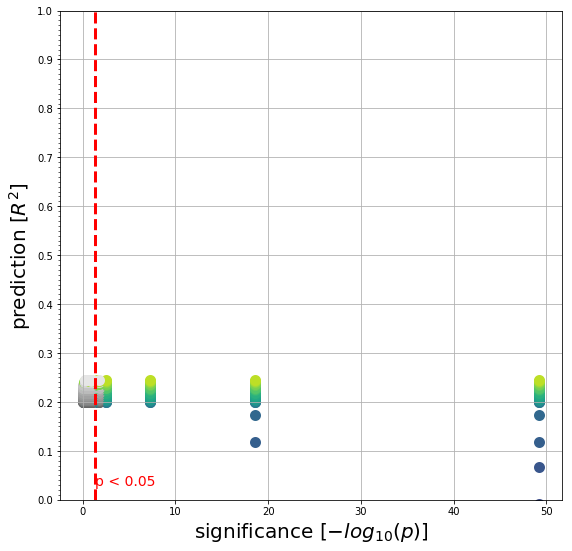

In [116]:
comment = "x^5 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_5 = X.copy()
X_5[:, 0:6] = X_5[:, 0:6]**5  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_5).sum(axis=1) + epsilon
C_grid = np.logspace(-1, 2, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: similar to X^3 4/5 path. variables are significant, the same 4/5 path. variables are selected as predictive; other than X^3 but similar to X^4 coefficients for other 4/5 relevant variables are messed up

# Multicollinearity with correct model, 1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.93 active_coefs: 40
alpha: 0.0133 acc: 0.93 active_coefs: 40
alpha: 0.0178 acc: 0.93 active_coefs: 40
alpha: 0.0237 acc: 0.93 active_coefs: 39
alpha: 0.0316 acc: 0.93 active_coefs: 36
alpha: 0.0422 acc: 0.93 active_coefs: 29
alpha: 0.0562 acc: 0.92 active_coefs: 21
alpha: 0.0750 acc: 0.92 active_coefs: 15
alpha: 0.1000 acc: 0.91 active_coefs: 12
alpha: 0.1334 acc: 0.90 active_coefs: 9
alpha: 0.1778 acc: 0.89 active_coefs: 9
alpha: 0.2371 acc: 0.87 active_coefs: 8
alpha: 0.3162 acc: 0.85 active_coefs: 7
alpha: 0.4217 acc: 0.81 active_coefs: 7
alpha: 0.5623 acc: 0.73 active_coefs: 7
alpha: 0.7499 acc: 0.64 active_coefs: 5
alpha: 1.0000 acc: 0.51 active_coefs: 3
alpha: 1.3335 acc: 0.30 active_coefs: 3
alpha: 1.7783 acc: 0.10 active_coefs: 2
alpha: 2.3714 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 active_coefs: 0
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0.00 

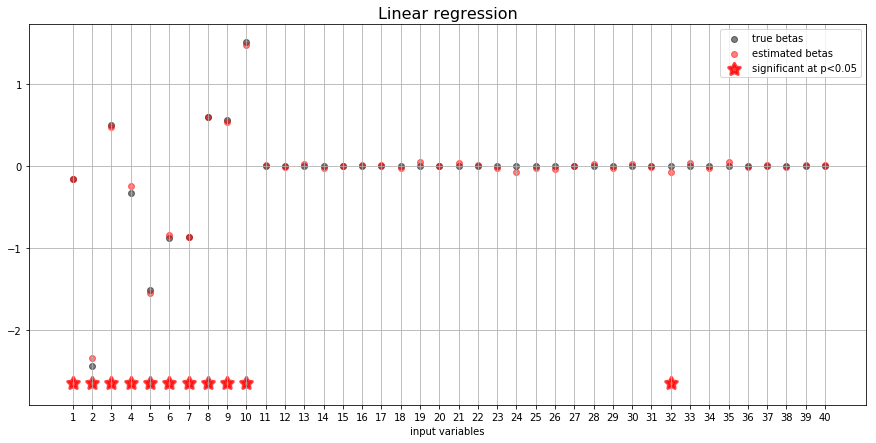

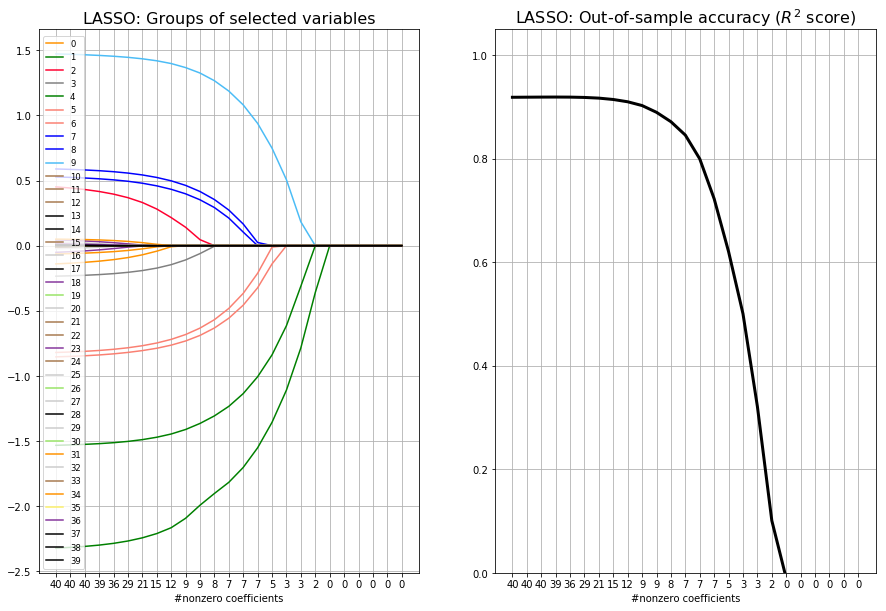

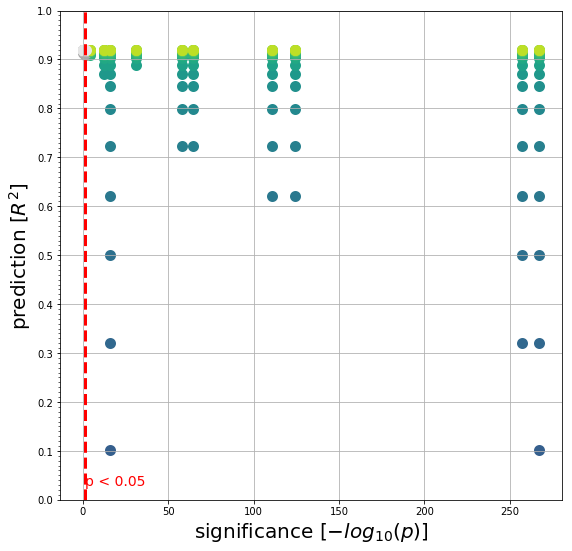

In [117]:
comment = "3 correlated vars at ~50% / dataset: 10/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 3
cov = np.ones((n_corr_feat, n_corr_feat)) * .5
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [29]:
### observation: 10/10 variables are significant, the 2/3 corr. variables are selected as predictive

alpha: 0.0100 acc: 0.94 active_coefs: 40
alpha: 0.0133 acc: 0.94 active_coefs: 40
alpha: 0.0178 acc: 0.94 active_coefs: 40
alpha: 0.0237 acc: 0.94 active_coefs: 39
alpha: 0.0316 acc: 0.94 active_coefs: 35
alpha: 0.0422 acc: 0.94 active_coefs: 28
alpha: 0.0562 acc: 0.94 active_coefs: 19
alpha: 0.0750 acc: 0.94 active_coefs: 14
alpha: 0.1000 acc: 0.94 active_coefs: 12
alpha: 0.1334 acc: 0.93 active_coefs: 10
alpha: 0.1778 acc: 0.92 active_coefs: 10
alpha: 0.2371 acc: 0.91 active_coefs: 9
alpha: 0.3162 acc: 0.89 active_coefs: 8
alpha: 0.4217 acc: 0.85 active_coefs: 8
alpha: 0.5623 acc: 0.79 active_coefs: 8
alpha: 0.7499 acc: 0.71 active_coefs: 6
alpha: 1.0000 acc: 0.62 active_coefs: 4
alpha: 1.3335 acc: 0.47 active_coefs: 3
alpha: 1.7783 acc: 0.34 active_coefs: 2
alpha: 2.3714 acc: 0.20 active_coefs: 1
alpha: 3.1623 acc: 0.01 active_coefs: 1
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0.00 

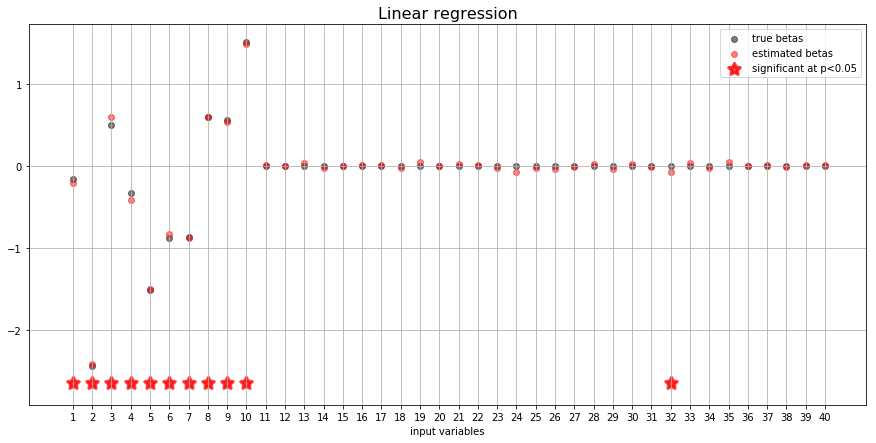

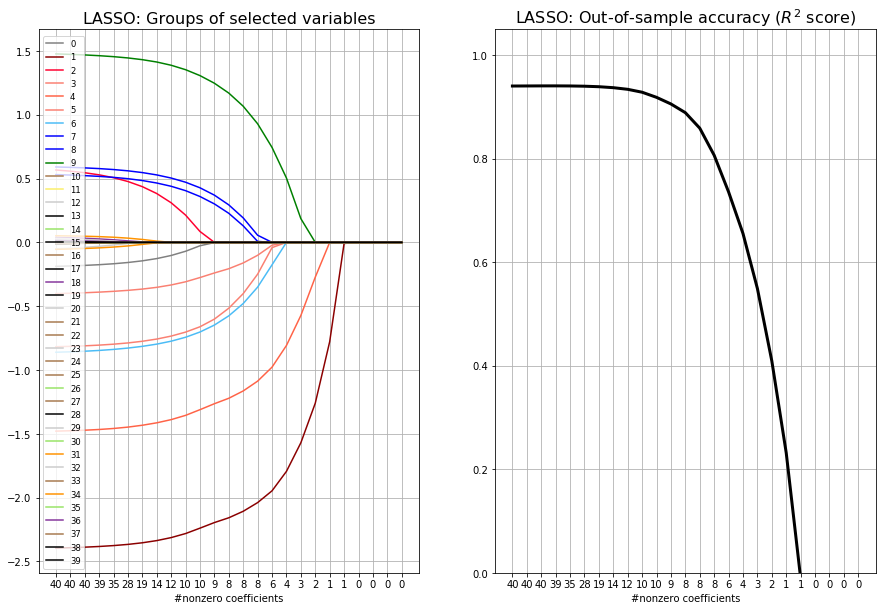

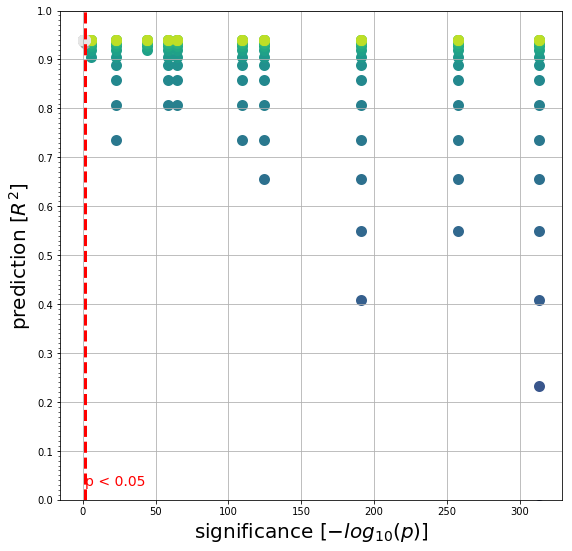

In [118]:
comment = "5 correlated vars at ~50% / dataset: 10/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 5
cov = np.ones((n_corr_feat, n_corr_feat)) * .5
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [31]:
### observation: 10/10 variables are significant, the 5/5 (?) corr. variables are selected as predictive

alpha: 0.0100 acc: 0.91 active_coefs: 40
alpha: 0.0133 acc: 0.91 active_coefs: 40
alpha: 0.0178 acc: 0.91 active_coefs: 40
alpha: 0.0237 acc: 0.91 active_coefs: 39
alpha: 0.0316 acc: 0.91 active_coefs: 33
alpha: 0.0422 acc: 0.91 active_coefs: 30
alpha: 0.0562 acc: 0.91 active_coefs: 22
alpha: 0.0750 acc: 0.90 active_coefs: 14
alpha: 0.1000 acc: 0.89 active_coefs: 11
alpha: 0.1334 acc: 0.88 active_coefs: 10
alpha: 0.1778 acc: 0.85 active_coefs: 9
alpha: 0.2371 acc: 0.82 active_coefs: 9
alpha: 0.3162 acc: 0.78 active_coefs: 5
alpha: 0.4217 acc: 0.74 active_coefs: 5
alpha: 0.5623 acc: 0.66 active_coefs: 5
alpha: 0.7499 acc: 0.61 active_coefs: 4
alpha: 1.0000 acc: 0.57 active_coefs: 3
alpha: 1.3335 acc: 0.50 active_coefs: 2
alpha: 1.7783 acc: 0.38 active_coefs: 2
alpha: 2.3714 acc: 0.18 active_coefs: 1
alpha: 3.1623 acc: -0.01 active_coefs: 0
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc: -0.01 

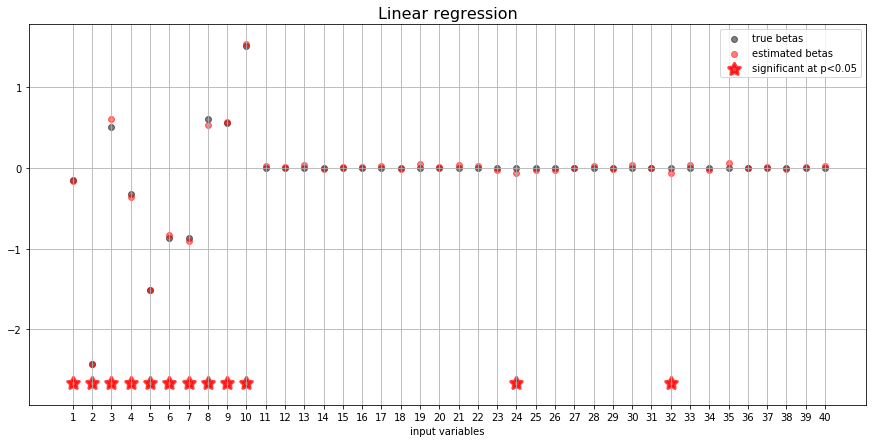

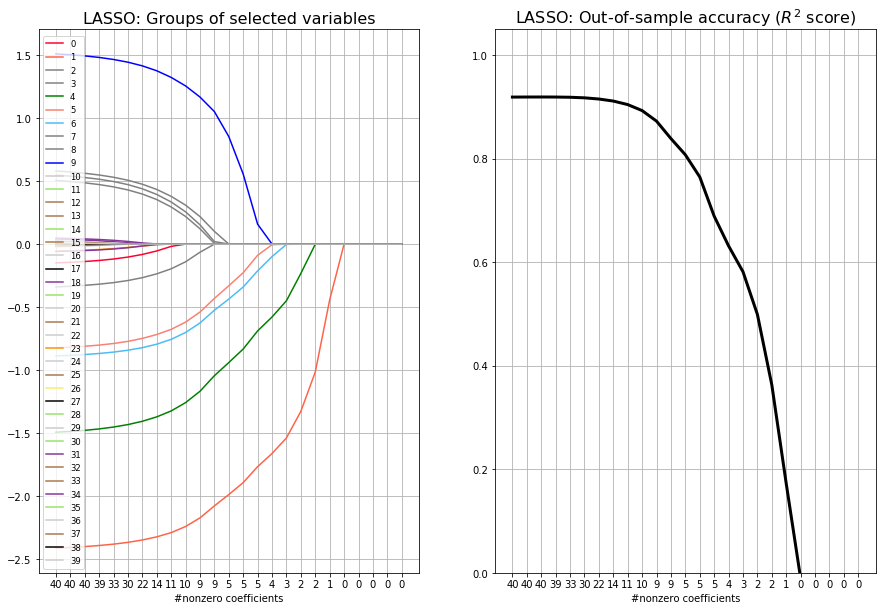

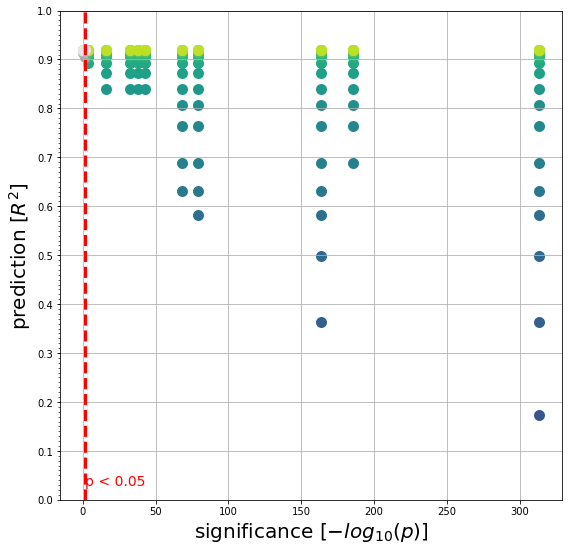

In [119]:
comment = "10 correlated vars at ~50% / dataset: 10/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .5
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

In [33]:
### observation: 10/10 variables are significant, the 9/10 (?) corr. variables are selected as predictive

alpha: 0.0100 acc: 0.92 active_coefs: 40
alpha: 0.0133 acc: 0.92 active_coefs: 40
alpha: 0.0178 acc: 0.92 active_coefs: 39
alpha: 0.0237 acc: 0.92 active_coefs: 39
alpha: 0.0316 acc: 0.93 active_coefs: 36
alpha: 0.0422 acc: 0.93 active_coefs: 28
alpha: 0.0562 acc: 0.92 active_coefs: 20
alpha: 0.0750 acc: 0.92 active_coefs: 14
alpha: 0.1000 acc: 0.92 active_coefs: 11
alpha: 0.1334 acc: 0.92 active_coefs: 9
alpha: 0.1778 acc: 0.91 active_coefs: 9
alpha: 0.2371 acc: 0.89 active_coefs: 9
alpha: 0.3162 acc: 0.87 active_coefs: 8
alpha: 0.4217 acc: 0.82 active_coefs: 8
alpha: 0.5623 acc: 0.75 active_coefs: 8
alpha: 0.7499 acc: 0.65 active_coefs: 6
alpha: 1.0000 acc: 0.52 active_coefs: 4
alpha: 1.3335 acc: 0.31 active_coefs: 3
alpha: 1.7783 acc: 0.09 active_coefs: 2
alpha: 2.3714 acc: -0.01 active_coefs: 0
alpha: 3.1623 acc: -0.01 active_coefs: 0
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc: -0.01 

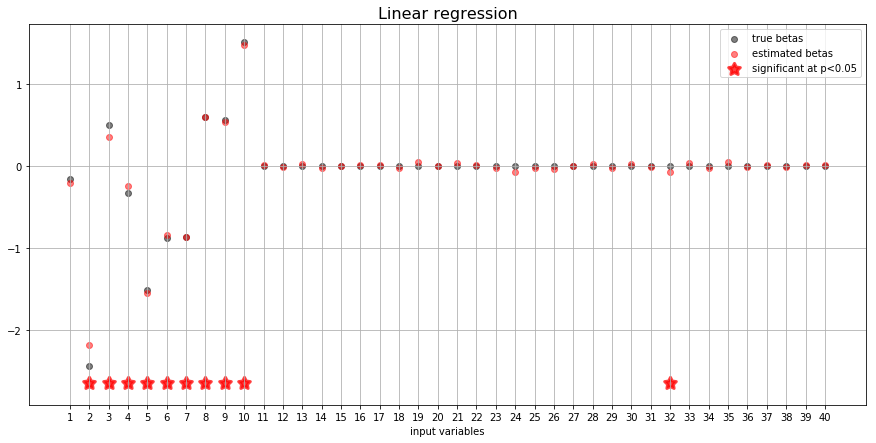

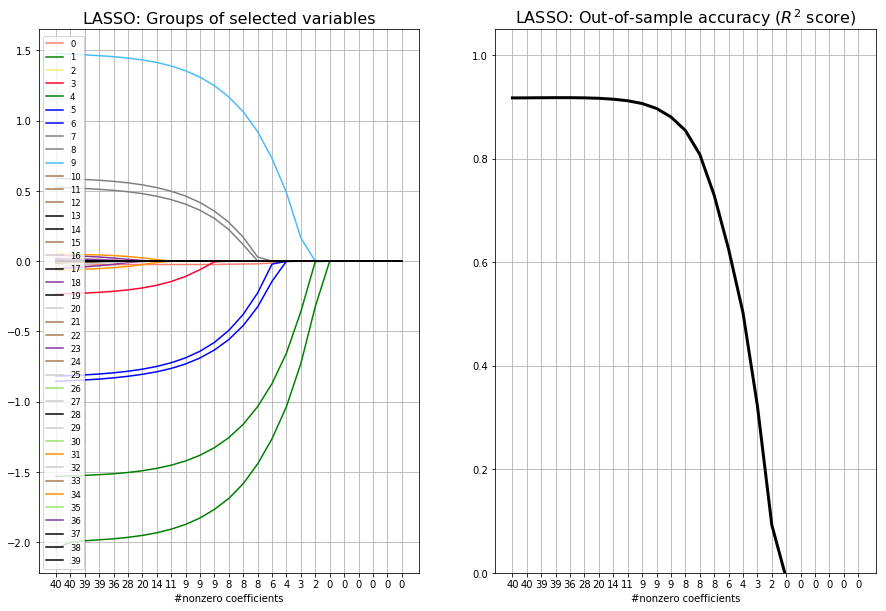

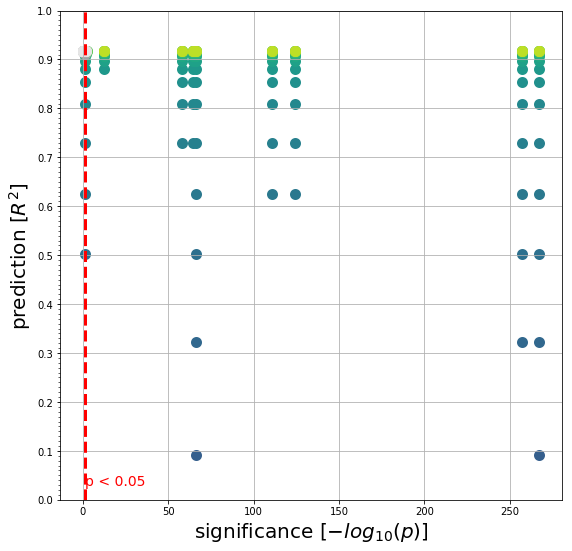

In [120]:
comment = "3 correlated vars at ~95% / dataset: 10/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 3
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 2/3 corr. variables are significant, different (!) 2/3 highly corr. variables are selected as predictive

alpha: 0.0100 acc: 0.94 active_coefs: 40
alpha: 0.0133 acc: 0.94 active_coefs: 40
alpha: 0.0178 acc: 0.94 active_coefs: 39
alpha: 0.0237 acc: 0.95 active_coefs: 39
alpha: 0.0316 acc: 0.95 active_coefs: 35
alpha: 0.0422 acc: 0.95 active_coefs: 25
alpha: 0.0562 acc: 0.95 active_coefs: 19
alpha: 0.0750 acc: 0.95 active_coefs: 12
alpha: 0.1000 acc: 0.94 active_coefs: 10
alpha: 0.1334 acc: 0.94 active_coefs: 8
alpha: 0.1778 acc: 0.94 active_coefs: 8
alpha: 0.2371 acc: 0.93 active_coefs: 8
alpha: 0.3162 acc: 0.92 active_coefs: 8
alpha: 0.4217 acc: 0.89 active_coefs: 8
alpha: 0.5623 acc: 0.84 active_coefs: 8
alpha: 0.7499 acc: 0.78 active_coefs: 6
alpha: 1.0000 acc: 0.71 active_coefs: 3
alpha: 1.3335 acc: 0.61 active_coefs: 3
alpha: 1.7783 acc: 0.51 active_coefs: 2
alpha: 2.3714 acc: 0.40 active_coefs: 2
alpha: 3.1623 acc: 0.21 active_coefs: 2
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc: -0.01 ac

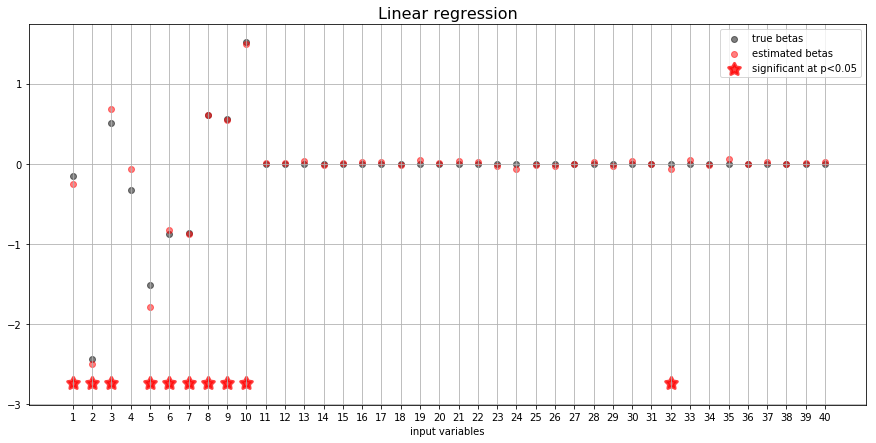

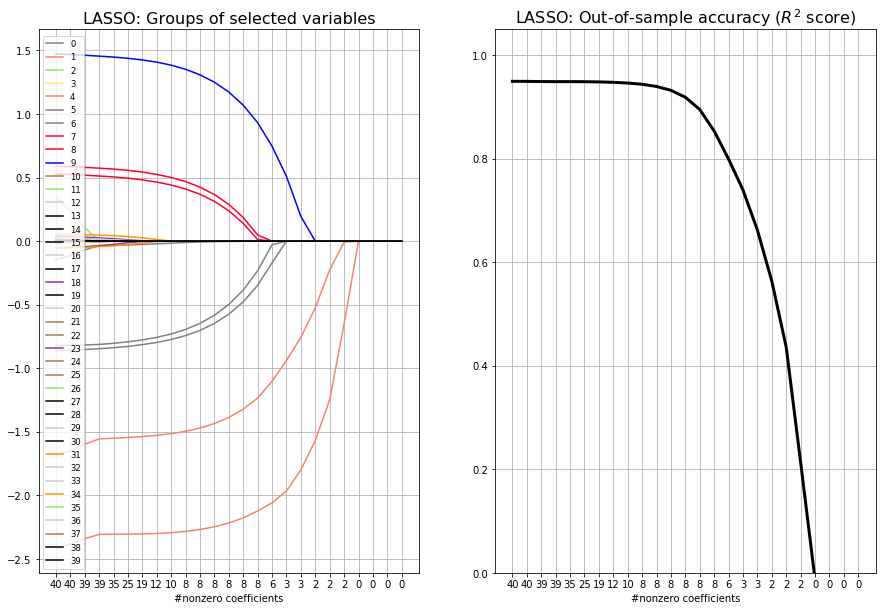

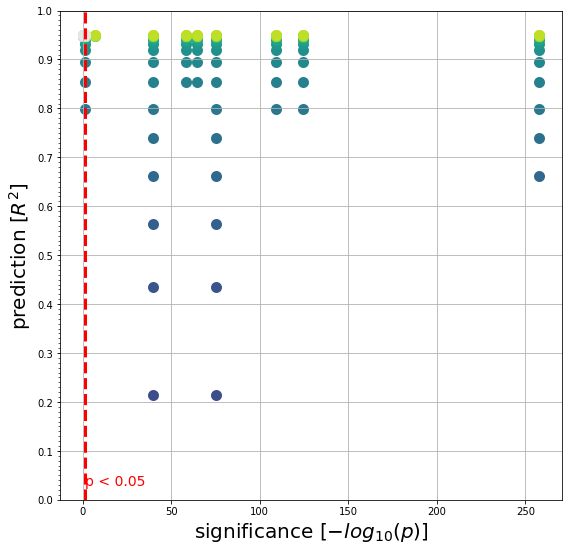

In [122]:
comment = "5 correlated vars at ~95% / dataset: 10/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 5
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 4/5 highly corr. variables are significant, different (!) 3/5 highly corr. variables are selected as predictive

alpha: 0.0100 acc: 0.90 active_coefs: 40
alpha: 0.0133 acc: 0.90 active_coefs: 40
alpha: 0.0178 acc: 0.90 active_coefs: 40
alpha: 0.0237 acc: 0.90 active_coefs: 40
alpha: 0.0316 acc: 0.90 active_coefs: 31
alpha: 0.0422 acc: 0.90 active_coefs: 26
alpha: 0.0562 acc: 0.90 active_coefs: 16
alpha: 0.0750 acc: 0.90 active_coefs: 11
alpha: 0.1000 acc: 0.90 active_coefs: 7
alpha: 0.1334 acc: 0.90 active_coefs: 5
alpha: 0.1778 acc: 0.90 active_coefs: 5
alpha: 0.2371 acc: 0.90 active_coefs: 5
alpha: 0.3162 acc: 0.90 active_coefs: 5
alpha: 0.4217 acc: 0.89 active_coefs: 5
alpha: 0.5623 acc: 0.88 active_coefs: 5
alpha: 0.7499 acc: 0.87 active_coefs: 4
alpha: 1.0000 acc: 0.83 active_coefs: 4
alpha: 1.3335 acc: 0.76 active_coefs: 3
alpha: 1.7783 acc: 0.63 active_coefs: 2
alpha: 2.3714 acc: 0.39 active_coefs: 2
alpha: 3.1623 acc: -0.00 active_coefs: 1
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0.00 ac

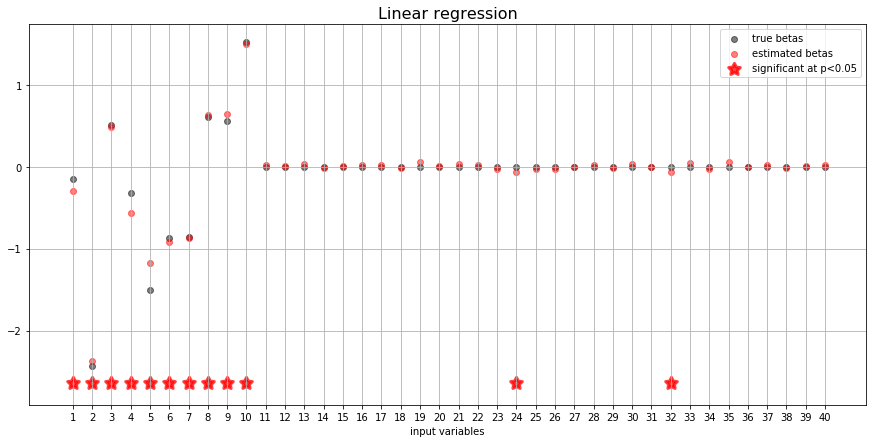

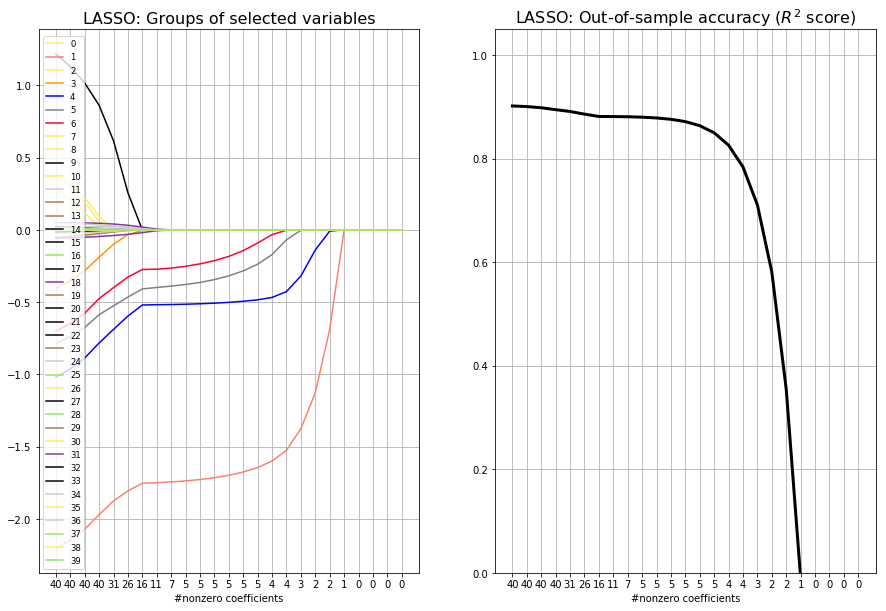

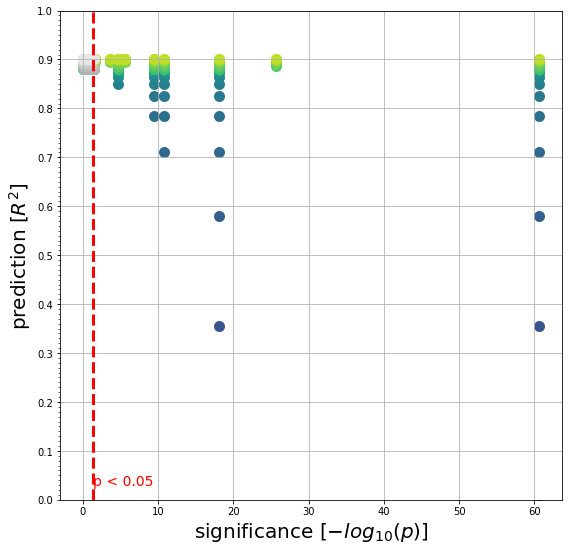

In [123]:
comment = "10 correlated vars at ~95% / dataset: 10/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: 10/10 highly corr. variables are significant, different (!) 4/10 highly corr. variables are selected as predictive with reasonable accuracy around R2=0.9 -> a few representative variables are easily found by Lasso without false positive while sign. testing yields 2 false positives -> corelation among variables appears to inflate Type-1 error

alpha: 0.0100 acc: 0.97 active_coefs: 39
alpha: 0.0133 acc: 0.97 active_coefs: 39
alpha: 0.0178 acc: 0.97 active_coefs: 38
alpha: 0.0237 acc: 0.97 active_coefs: 34
alpha: 0.0316 acc: 0.96 active_coefs: 30
alpha: 0.0422 acc: 0.96 active_coefs: 21
alpha: 0.0562 acc: 0.96 active_coefs: 18
alpha: 0.0750 acc: 0.96 active_coefs: 16
alpha: 0.1000 acc: 0.96 active_coefs: 16
alpha: 0.1334 acc: 0.96 active_coefs: 16
alpha: 0.1778 acc: 0.95 active_coefs: 15
alpha: 0.2371 acc: 0.95 active_coefs: 15
alpha: 0.3162 acc: 0.94 active_coefs: 15
alpha: 0.4217 acc: 0.94 active_coefs: 15
alpha: 0.5623 acc: 0.92 active_coefs: 15
alpha: 0.7499 acc: 0.90 active_coefs: 14
alpha: 1.0000 acc: 0.86 active_coefs: 13
alpha: 1.3335 acc: 0.79 active_coefs: 12
alpha: 1.7783 acc: 0.69 active_coefs: 11
alpha: 2.3714 acc: 0.54 active_coefs: 9
alpha: 3.1623 acc: 0.29 active_coefs: 7
alpha: 4.2170 acc: -0.00 active_coefs: 1
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc

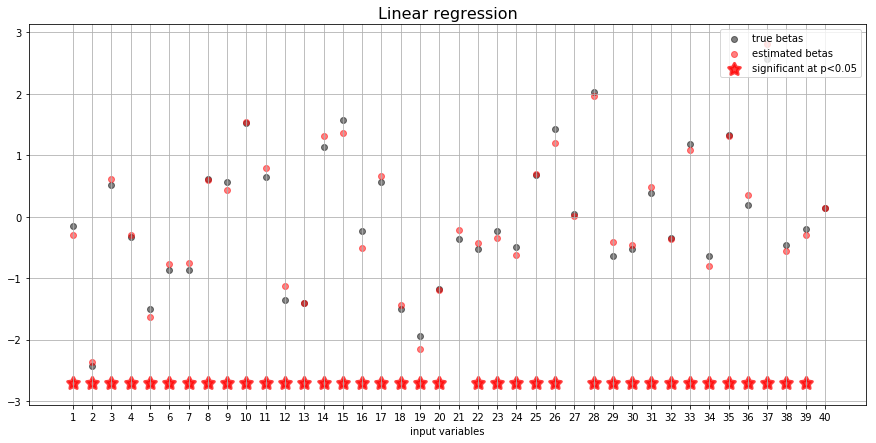

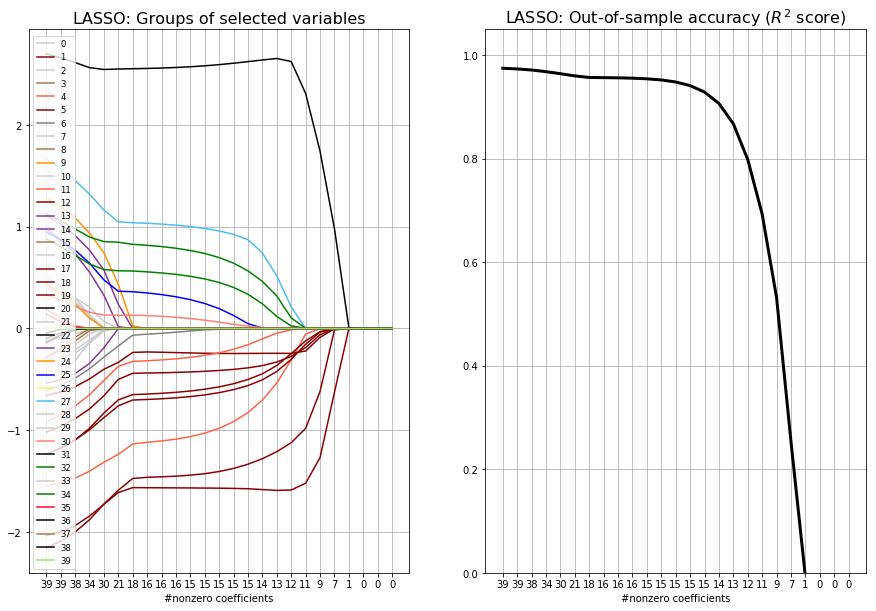

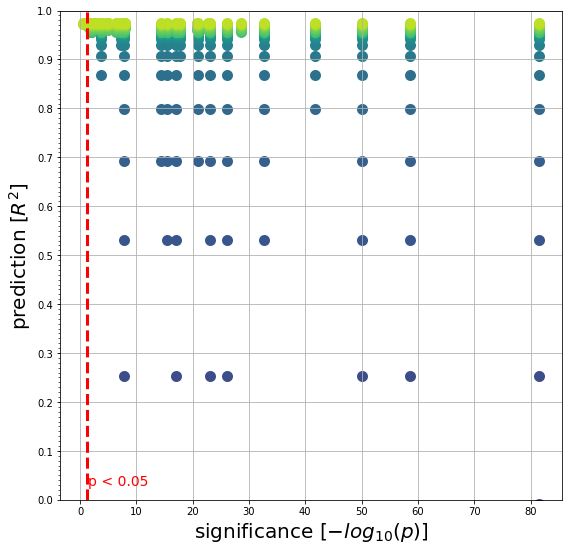

In [124]:
comment = "4 groups of 10 correlated vars at ~95% / dataset: 40/40 relevant variables, linear ground truth, some noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
#X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:10] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 10:20] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 20:30] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 30:40] = X_corr

y = (true_coefs * X).sum(axis=1) + epsilon
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

### observation: significance yields 3 false negatives; Lasso yields stable R2>0.9 with roughly 16/40 active variables capturing 4 real sources of variation

alpha: 0.0100 acc: 0.99 active_coefs: 35
alpha: 0.0133 acc: 0.98 active_coefs: 34
alpha: 0.0178 acc: 0.96 active_coefs: 33
alpha: 0.0237 acc: 0.94 active_coefs: 31
alpha: 0.0316 acc: 0.91 active_coefs: 26
alpha: 0.0422 acc: 0.88 active_coefs: 19
alpha: 0.0562 acc: 0.83 active_coefs: 17
alpha: 0.0750 acc: 0.80 active_coefs: 15
alpha: 0.1000 acc: 0.80 active_coefs: 13
alpha: 0.1334 acc: 0.80 active_coefs: 13
alpha: 0.1778 acc: 0.79 active_coefs: 13
alpha: 0.2371 acc: 0.78 active_coefs: 13
alpha: 0.3162 acc: 0.76 active_coefs: 13
alpha: 0.4217 acc: 0.73 active_coefs: 12
alpha: 0.5623 acc: 0.67 active_coefs: 11
alpha: 0.7499 acc: 0.58 active_coefs: 11
alpha: 1.0000 acc: 0.44 active_coefs: 7
alpha: 1.3335 acc: 0.29 active_coefs: 6
alpha: 1.7783 acc: 0.04 active_coefs: 2
alpha: 2.3714 acc: -0.01 active_coefs: 0
alpha: 3.1623 acc: -0.01 active_coefs: 0
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc:

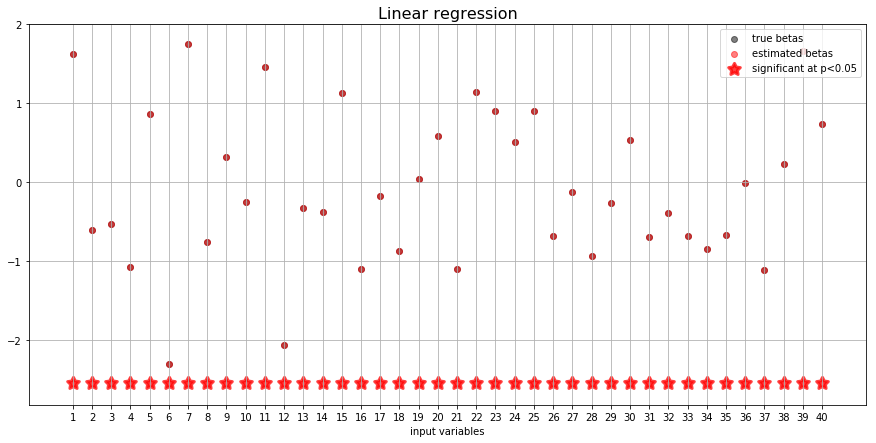

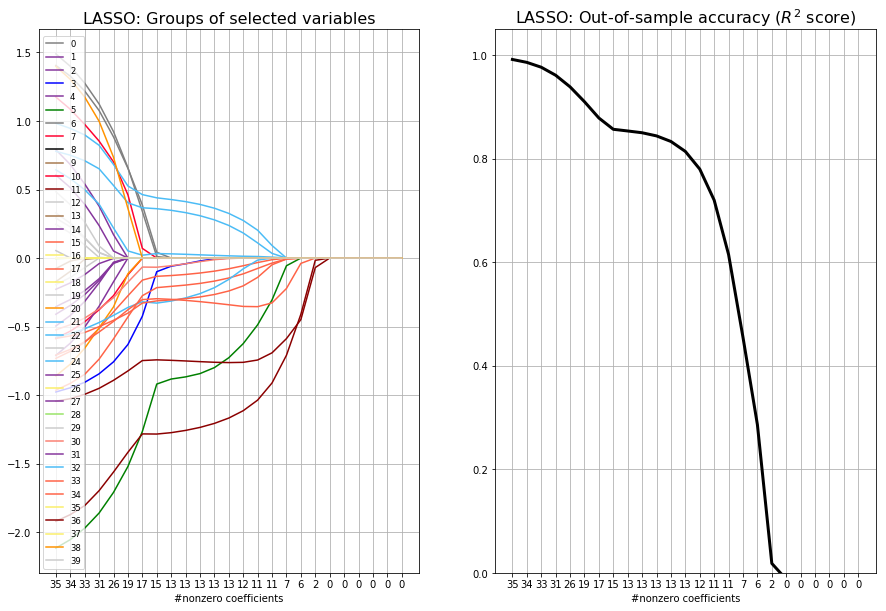

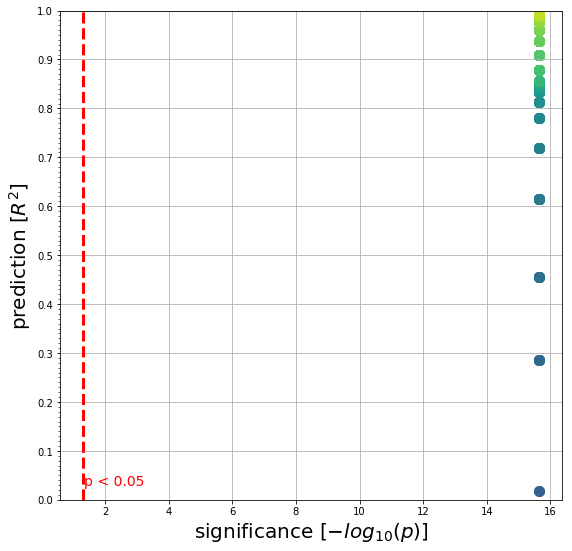

In [125]:
comment = "4 groups of 10 correlated vars at ~95% / dataset: 40/40 relevant variables, linear ground truth, NO noise"
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
#epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:10] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 10:20] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 20:30] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 30:40] = X_corr

#y = (true_coefs * X).sum(axis=1) + epsilon
y = (true_coefs * X).sum(axis=1)
C_grid = np.logspace(-2, 1, 25)

run_lasso(X, y, comment, n_samples, n_feat,
          n_feat_relevant, C_grid=C_grid)

# Summary 

dataset: 10/40 variables relevant, linear ground truth, some noise
False 1.26302476958e-18 11 0.722118442333

dataset: 10/40 variables relevant, linear ground truth, some noise
False 1.26302476958e-18 11 0.722118442333

dataset: 20/40 variables relevant, linear ground truth, some noise
False 6.30761429734e-20 17 0.861085349967

dataset: 30/40 variables relevant, linear ground truth, some noise
False 9.04688139435e-28 25 0.932098782862

dataset: 40/40 variables relevant, linear ground truth, some noise
False 9.04688139435e-28 34 0.944988438592

dataset: 10/40 variables relevant, linear ground truth, some noise
False 6.25407738595e-267 11 0.924743235144

dataset: 20/40 variables relevant, linear ground truth, some noise
False 1.98379691076e-307 21 0.964327764623

dataset: 30/40 variables relevant, linear ground truth, some noise
False 1.98379691076e-307 30 0.972198689331

dataset: 40/40 variables relevant, linear ground truth, some noise
False 1.98379691076e-307 39 0.978898424293

datase

ValueError: zero-size array to reduction operation minimum which has no identity

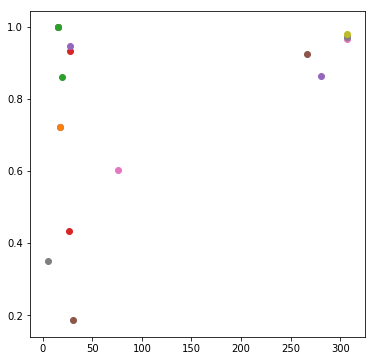

In [126]:
for sim in simulations:
    pval = sim['pvals'].min()
    n_pval = np.sum(sim['pvals'] <= 0.05)
    r2 = sim['acc_list'].max()
    print(sim['comment'])
    print(pval >= 0.05, pval, n_pval, r2)
    print("")

plt.figure(figsize=(6, 6))
for sim in simulations:
    n_rel = sim['n_feat_relevant']
    pval = sim['pvals'][:n_rel].min()
    n_pval = np.sum(sim['pvals'][:n_rel] <= 0.05)
    r2 = sim['acc_list'].max()
    plt.scatter(-np.log10(pval), r2)

plt.xlabel(r'significance [$-log_{10}(p)$]', fontsize=20, fontweight=150)
plt.ylabel(r'prediction [$R^2$]', fontsize=20, fontweight=150)
# plt.ylim(0, 1)
plt.grid(True)
ax = plt.gca()
plt.axvline(
    -np.log10(0.05), color='red', linestyle='--', linewidth=3)
plt.annotate('p < 0.05', xy=(-np.log10(0.045), 0.03), color='red', fontsize=14)
ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticks(np.arange(0.01, 1, 0.01), minor=True);


plt.figure(figsize=(6, 6))
for sim in simulations:
    n_rel = sim['n_feat_relevant']
    pval = sim['pvals'][:n_rel].min()
    n_pval = np.sum(sim['pvals'][:n_rel] <= 0.05)
    r2 = sim['acc_list'].max()
    plt.scatter(n_pval / n_rel, r2)

plt.xlabel(r'Number of p-values < 0.05', fontsize=20, fontweight=150)
plt.ylabel(r'prediction [$R^2$]', fontsize=20, fontweight=150)
# plt.ylim(0, 1)
plt.grid(True)
ax = plt.gca()
ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticks(np.arange(0.01, 1, 0.01), minor=True);

In [133]:
np.sum(simulations[0]['coefs'] != 0.)

530